In [1]:
import torch
import numpy as np

from torch.nn import Linear,ReLU,Tanh,Sigmoid, SiLU
from torch.autograd import grad
from torch.optim import Adam, SGD, AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau, CosineAnnealingLR

import time
import copy
from os import path
import sys

import matplotlib.pyplot as plot
np.set_printoptions(threshold=np.inf)

cuda = torch.device('cuda')
torch.backends.cudnn.benchmark = True

In [2]:
def D(x,f): # Derivative helper
    return grad(f, x,grad_outputs=torch.ones(x.shape,device=cuda), create_graph=True)[0]

In [3]:
class pdeNet(torch.nn.Module): # Blochnet class
    def __init__(self,dims,out_dims,f_layers,f_neurons,e_layers,e_neurons):
        super(pdeNet,self).__init__()
        self.cuda(device=cuda)
        
        self.funcf = SiLU()
        self.enf = SiLU()
        
        self.periodic_activation = SiLU()
        
        
        self.einput = Linear(dims,e_neurons)
        self.e_layers = torch.nn.ModuleList([Linear(e_neurons, e_neurons) for i in range(e_layers)])
        self.efout = Linear(e_neurons,1)
        

        self.finput = Linear(2*dims,f_neurons)        
        self.fperiodic = Linear(f_neurons,f_neurons)
        self.f_layers = torch.nn.ModuleList([Linear(f_neurons, f_neurons) for i in range(f_layers-1)])
        self.fout = Linear(f_neurons,out_dims)
        
        
    def forward(self,x,y,kx,ky,V,wavefunction = False):

        E = self.einput(torch.cat((kx,ky),1))
        
        for h in self.e_layers:
            E = self.enf(h(E))
        
        Eout = self.efout(E) 
        
        L = self.finput(torch.cat((x,y,kx,ky),1))
        L = self.periodic_activation((self.fperiodic(L))) # At one point I was exploring using a periodic activation function (sine) for the first layer following claims from a paper that 
        # this would improve PINN performance on periodic domains. I've left the option to use a different first-layer activation in the model, although it is currently not being used.
        
        for h in self.f_layers:
            L = self.funcf(h(L))
        
        out = self.fout(L)
        
        return out, Eout
    
    
class Potential(torch.nn.Module):
    def __init__(self,V0,well_type='free',V1=0,a=1,b=1,theta=np.pi/4,a1=1,b1=1,offset=0.5):
        super(Potential,self).__init__()
        self.V0 = V0
        self.V1 = V1
        
        self.well_type = well_type
        self.a = a
        self.b = b
        
        self.a1 = a1
        self.b1 = b1
        self.offset = offset/2
        
        self.rot_alpha = np.cos(theta)
        self.rot_beta = np.sin(theta)
        
    def forward(self,x,y):
        
        
        if self.well_type == 'free':
            return torch.zeros_like(grid)
        elif self.well_type == 'squared':
            return (1/10)*self.V0/(0.1+(10*(x**2+y**2)))
        elif self.well_type == 'oval':
            return (1/10)*self.V0/(0.1+(10*(self.a*x**2+self.b*y**2)))
        elif self.well_type == 'doublewell':
            return (1/10)*self.V0/(0.1+(10*(self.a*(x*self.rot_alpha-y*self.rot_beta-self.offset)**2+self.b*(x*self.rot_beta+y*self.rot_alpha-self.offset)**2)))+(1/10)*self.V1/(0.1+(10*(self.a1*(x*self.rot_alpha-y*self.rot_beta+self.offset)**2+self.b1*(x*self.rot_beta+y*self.rot_alpha+self.offset)**2)))
        elif self.well_type == 'kp':
            device = x.device
            x = x.cpu().data.numpy(); y = y.cpu().data.numpy()

            V = (np.heaviside(np.abs(self.a*(x*self.rot_alpha-y*self.rot_beta))+np.abs(self.b*(x*self.rot_beta+y*self.rot_alpha))-1, 0)-1)*-self.V0
            return torch.from_numpy(V).to(device)
        elif self.well_type == 'fiveatom':
            center = (1/10)*self.V1/(0.1+(self.a*x)**2 + (self.b*y)**2)
            topleft = (1/10)*self.V0/(0.1+(self.a1*(x+0.5))**2 + (self.b1*(y-0.5))**2)
            topright = (1/10)*self.V0/(0.1+(self.a1*(x-0.5))**2 + (self.b1*(y-0.5))**2)
            botleft = (1/10)*self.V0/(0.1+(self.a1*(x+0.5))**2 + (self.b1*(y+0.5))**2)
            botright = (1/10)*self.V0/(0.1+(self.a1*(x-0.5))**2 + (self.b1*(y+0.5))**2)
        
        return center + topleft + topright + botleft + botright
        
        
def IBZ(pts,vert,basis,radius):
    A = vert[0]; B = vert[1]; C = vert[2] 
    b_1 = basis[0]; b_2 = basis[1]
    
    IBZ_Vertex = torch.tensor([[A[0],A[1]],[B[0],B[1]],[C[0],C[1]]])
    rand1 = torch.rand((int(pts))) ; rand2 = torch.rand((int(pts)))
    Px = (1-torch.sqrt(rand1))*IBZ_Vertex[0,0] + (torch.sqrt(rand1)*(1-rand2))*IBZ_Vertex[1,0] + (torch.sqrt(rand1)*rand2)*IBZ_Vertex[2,0]
    Py = (1-torch.sqrt(rand1))*IBZ_Vertex[0,1] + (torch.sqrt(rand1)*(1-rand2))*IBZ_Vertex[1,1] + (torch.sqrt(rand1)*rand2)*IBZ_Vertex[2,1]
    
    

    b_1_rand = b_1*torch.randint(-1*radius,radius+1,(pts,)); b_2_rand = b_2*torch.randint(-1*radius,radius+1,(pts,))

    Px_shift = Px + b_1_rand; Py_shift = Py + b_2_rand
    P = torch.cat((Px_shift.reshape(-1,1),Py_shift.reshape(-1,1)),1)
    return P

    

In [4]:
def blochLoss(nn,x,y,kx,ky,V):
    V = V(x,y)
    u,E = nn(x,y,kx,ky,V)

    k_r_dot = kx*x + ky*y
    
    v = u[:,0].reshape(-1,1)*torch.cos(k_r_dot)-u[:,1].reshape(-1,1)*torch.sin(k_r_dot) 
    w = u[:,0].reshape(-1,1)*torch.sin(k_r_dot)+u[:,1].reshape(-1,1)*torch.cos(k_r_dot) # // Wavefunction form
    
    dv_x = D(x,v); dw_x = D(x,w) ; dv_y = D(y,v); dw_y = D(y,w)
    
    
    ddv_x = D(x,dv_x); ddw_x = D(x,dw_x) ; ddv_y = D(y,dv_y); ddw_y = D(y,dw_y)
    
    u = torch.complex(v.reshape(-1,1),w.reshape(-1,1))
    ddu = torch.complex((ddv_x.reshape(-1,1)+ddv_y.reshape(-1,1)),(ddw_x.reshape(-1,1)+ddw_y.reshape(-1,1)))
    
    f = E*u + (1/2)*ddu - V*u
    
    L = (f.real.pow(2)+f.imag.pow(2)).mean()
    
    return L

def BClossx(nn,ibzparams,V,pts):
    
    vert = ibzparams[0]; basis = ibzparams[1]; radius = ibzparams[2] 
    
    zeros = torch.linspace(-0.5,-0.5,int(pts/2)).to(cuda);ones = torch.linspace(0.5,0.5,int(pts/2)).to(cuda)
    
    x = torch.rand((int(pts/2)))-0.5
    x = torch.cat((x,x),0).to(cuda).reshape(-1,1); x.requires_grad = True
    y = torch.cat((zeros,ones),0).reshape(-1,1) ; y.requires_grad = True
    
    
    k = IBZ(int(pts/2),vert,basis,radius).to(cuda)
    k.requires_grad = True
    
    kx = torch.cat((k[:,0],k[:,0]),0).reshape(-1,1) ; ky = torch.cat((k[:,1],k[:,1]),0).reshape(-1,1)
    

    u, E = nn(x,y,kx,ky,V(x,y))
    
    dx = D(x,u[:,0].reshape(-1,1)) + D(y,u[:,0].reshape(-1,1))
    idx = D(x,u[:,1].reshape(-1,1)) + D(y,u[:,1].reshape(-1,1)) 
    
    x0 = u[:,0].reshape(-1,1).chunk(2)[0] ; x1 = u[:,0].reshape(-1,1).chunk(2)[1]
    ix0 = u[:,1].reshape(-1,1).chunk(2)[0] ; ix1 = u[:,1].reshape(-1,1).chunk(2)[1]
    
    dx0 = dx.reshape(-1,1).chunk(2)[0] ; dx1 = dx.reshape(-1,1).chunk(2)[1]
    dix0 = idx.reshape(-1,1).chunk(2)[0] ; dix1 = idx.reshape(-1,1).chunk(2)[1]
    
    L = (x1-x0).pow(2).mean() + (ix1-ix0).pow(2).mean() + (dx1-dx0).pow(2).mean() + (dix1-dix0).pow(2).mean() 
    
    return L

def BClossy(nn,ibzparams,V,pts):
    
    vert = ibzparams[0]; basis = ibzparams[1]; radius = ibzparams[2] 
     
    
    zeros = torch.linspace(-0.5,-0.5,int(pts/2)).to(cuda);ones = torch.linspace(0.5,0.5,int(pts/2)).to(cuda)
    
         
    y = torch.rand((int(pts/2)))-0.5
    y = torch.cat((y,y),0).to(cuda).reshape(-1,1); y.requires_grad = True
    x = torch.cat((zeros,ones),0).reshape(-1,1); x.requires_grad = True
    
    
    k = IBZ(int(pts/2),vert,basis,radius).to(cuda)
    k.requires_grad = True
    
    kx = torch.cat((k[:,0],k[:,0]),0).reshape(-1,1) ; ky = torch.cat((k[:,1],k[:,1]),0).reshape(-1,1)
    

    u, E = nn(x,y,kx,ky,V(x,y))
    
    dx = D(y,u[:,0].reshape(-1,1)) + D(x,u[:,0].reshape(-1,1)) 
    idx = D(y,u[:,1].reshape(-1,1)) + D(x,u[:,1].reshape(-1,1))
    
    x0 = u[:,0].reshape(-1,1).chunk(2)[0] ; x1 = u[:,0].reshape(-1,1).chunk(2)[1]
    ix0 = u[:,1].reshape(-1,1).chunk(2)[0] ; ix1 = u[:,1].reshape(-1,1).chunk(2)[1]
    
    dx0 = dx.reshape(-1,1).chunk(2)[0] ; dx1 = dx.reshape(-1,1).chunk(2)[1]
    dix0 = idx.reshape(-1,1).chunk(2)[0] ; dix1 = idx.reshape(-1,1).chunk(2)[1]
    
    L = (x1-x0).pow(2).mean() + (ix1-ix0).pow(2).mean() + (dx1-dx0).pow(2).mean() + (dix1-dix0).pow(2).mean() 
    
    return L

def BCloss(nn,ibzparams,V,pts):
    return BClossx(nn,ibzparams,V,pts) + BClossy(nn,ibzparams,V,pts)


def normLoss(nn,ibzparams,V,pts=100,kpts=100):
    vert = ibzparams[0]; basis = ibzparams[1]; radius = ibzparams[2] 
    
    k = IBZ(1,vert,basis,radius).to(cuda).expand(pts**2,-1)
    grid = torch.cartesian_prod(torch.linspace(-0.5,0.5,pts).to(cuda), torch.linspace(-0.5,0.5,pts).to(cuda))
    x = grid[:,0] ; y = grid[:,1]
    
    for i in range(kpts-1):
        k = torch.cat((k,IBZ(1,vert,basis,radius).to(cuda).expand(pts**2,-1)),0)
        x = torch.cat((x,grid[:,0]),0) ; y = torch.cat((y,grid[:,1]),0)     

    k.requires_grad = True 
    x.requires_grad = True ; y.requires_grad = True    
    u, E = nn(x.reshape(-1,1),y.reshape(-1,1),k[:,0].reshape(-1,1),k[:,1].reshape(-1,1),V(x.reshape(-1,1),y.reshape(-1,1)))

    pdist = (u[:,0].reshape(-1,1).pow(2) + u[:,1].reshape(-1,1).pow(2)).chunk(kpts)
    L = 0.0

    for i in range(len(pdist)):
        L += (torch.trapezoid(torch.trapezoid(pdist[i].reshape(pts,pts), dx=1/pts, dim=1), dx=1/pts, dim=0)-1).pow(2).mean()
    return L.mean()

def wedgepts(pts):
    b1 = 2*np.pi ; b2 = 2*np.pi

    kx1 = torch.linspace(0*np.pi,1*np.pi,pts).to(cuda) ; kx2 = torch.linspace(1*np.pi,1*np.pi,pts).to(cuda) ; kx3 = torch.linspace(1*np.pi,0*np.pi,2*pts).to(cuda)
    ky1 = torch.linspace(0,0,pts).to(cuda) ; ky2 = torch.linspace(0,1*np.pi,pts).to(cuda) ; ky3 = torch.linspace(1*np.pi,0*np.pi,2*pts).to(cuda)
    kx = torch.cat((kx1,kx2,kx3),0) ; ky = torch.cat((ky1,ky2,ky3),0)
    
    kx = kx+torch.randint(-1,2,(4*pts,),device='cuda')*b1 ; ky = ky+torch.randint(-1,2,(4*pts,),device='cuda')*b2
    
    return torch.cat((kx.reshape(-1,1),ky.reshape(-1,1)),1)

def freeEnergySoln(kx,ky):
    return 1/2*(kx**2+ky**2)

In [5]:
def expectationEnergy(nn,k,V,pts):
    # <u|H|u>
    x0 = torch.linspace(-0.5,0.5,pts).to(cuda) ; y0 = torch.linspace(-0.5,0.5,pts).to(cuda)
    grid = torch.cartesian_prod(x0, y0)
    grid.requires_grad = True
    
    kx = torch.linspace(k[0],k[0],pts**2).to(cuda).reshape(-1,1) ; ky = torch.linspace(k[1],k[1],pts**2).to(cuda).reshape(-1,1)
    x = grid[:,0].reshape(-1,1) ; y = grid[:,1].reshape(-1,1)
    
    V = V(x,y)
    u,E = nn(x,y,kx,ky,V)
    
    # Let u(x,y) = v+wi
    k_r_dot = k[0]*x + k[1]*y
    
    v = u[:,0].reshape(-1,1)*torch.cos(k_r_dot)-u[:,1].reshape(-1,1)*torch.sin(k_r_dot) 
    w = u[:,0].reshape(-1,1)*torch.sin(k_r_dot)+u[:,1].reshape(-1,1)*torch.cos(k_r_dot) # // Wavefunction form
    
    dv_x = D(x,v); dw_x = D(x,w) ; dv_y = D(y,v); dw_y = D(y,w)
    
    
    ddv_x = D(x,dv_x); ddw_x = D(x,dw_x) ; ddv_y = D(y,dv_y); ddw_y = D(y,dw_y)
    
    psi = torch.complex(v.reshape(-1,1),w.reshape(-1,1))
    
    ddpsi = torch.complex((ddv_x.reshape(-1,1)+ddv_y.reshape(-1,1)),(ddw_x.reshape(-1,1)+ddw_y.reshape(-1,1)))
    H = (-1/2)*ddpsi + V*psi 
    
    E = torch.trapezoid(torch.trapezoid((H*torch.conj(psi)).real.reshape(pts,pts), x0, dim=1), y0, dim=0)
    
    return E

In [6]:
dims = 2; out_dims = 2 ; f_layers = 4; f_neurons = 384; e_layers = 4; e_neurons = 128 #dims = 2; f_layers = 7; f_neurons = 256; e_layers = 4; e_neurons = 128 #dims = 2; f_layers = 5; f_neurons = 384; e_layers = 4; e_neurons = 128
nn1 = pdeNet(dims,out_dims,f_layers,f_neurons,e_layers,e_neurons)
nn1.to(cuda)

pdeNet(
  (funcf): SiLU()
  (enf): SiLU()
  (periodic_activation): SiLU()
  (einput): Linear(in_features=2, out_features=128, bias=True)
  (e_layers): ModuleList(
    (0-3): 4 x Linear(in_features=128, out_features=128, bias=True)
  )
  (efout): Linear(in_features=128, out_features=1, bias=True)
  (finput): Linear(in_features=4, out_features=384, bias=True)
  (fperiodic): Linear(in_features=384, out_features=384, bias=True)
  (f_layers): ModuleList(
    (0-2): 3 x Linear(in_features=384, out_features=384, bias=True)
  )
  (fout): Linear(in_features=384, out_features=2, bias=True)
)

In [7]:
num_weights =  sum(p.numel() for p in nn1.parameters())
print(num_weights)

660611


In [8]:
optimizer = AdamW(nn1.parameters(),lr=8e-4) #optimizer = Adam(nn1.parameters(), lr=4e-4)
scheduler = CosineAnnealingLR(optimizer,T_max=60000,eta_min=1e-10)

In [9]:
loss_history = [] ; bloch_loss_history = [] ; bc_loss_history = [] ; norm_loss_history = []
lr_history = []
lossLim = 10e10

In [10]:
V0 = 0; V1 = -30 
V = Potential(V0=V0,V1=V1,well_type='fiveatom',a=2,b=2,a1=2,b1=2)

Text(76.22222222222221, 0.5, 'y')

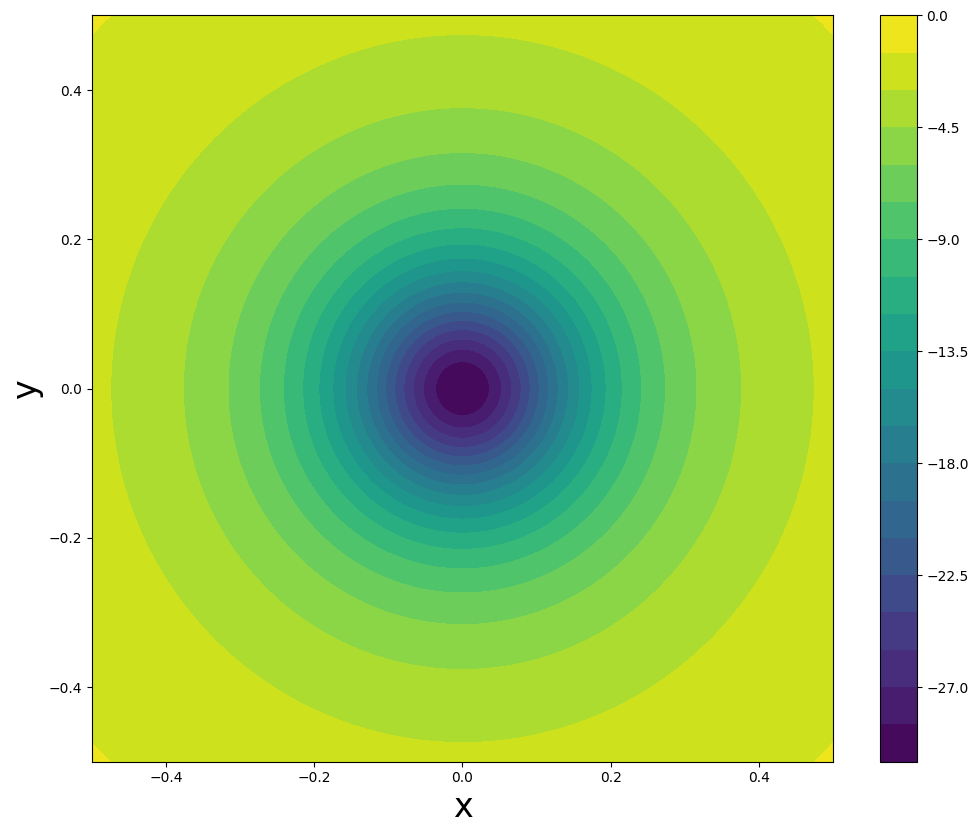

In [11]:
plot.figure(figsize = (10,8))

x = torch.linspace(-0.5,0.5,500) ; y = torch.linspace(-0.5,0.5,500) ; grid = torch.cartesian_prod(x, y)
cbarmap = plot.colormaps['viridis']


plot.contourf(x.cpu().detach().numpy(),y.cpu().detach().numpy(),V(grid[:,0],grid[:,1]).reshape(500,500),20,cmap=cbarmap)
plot.tight_layout()
plot.colorbar()
plot.xlabel('x',fontsize=24)
plot.ylabel('y',fontsize=24)

Text(0, 0.5, 'V')

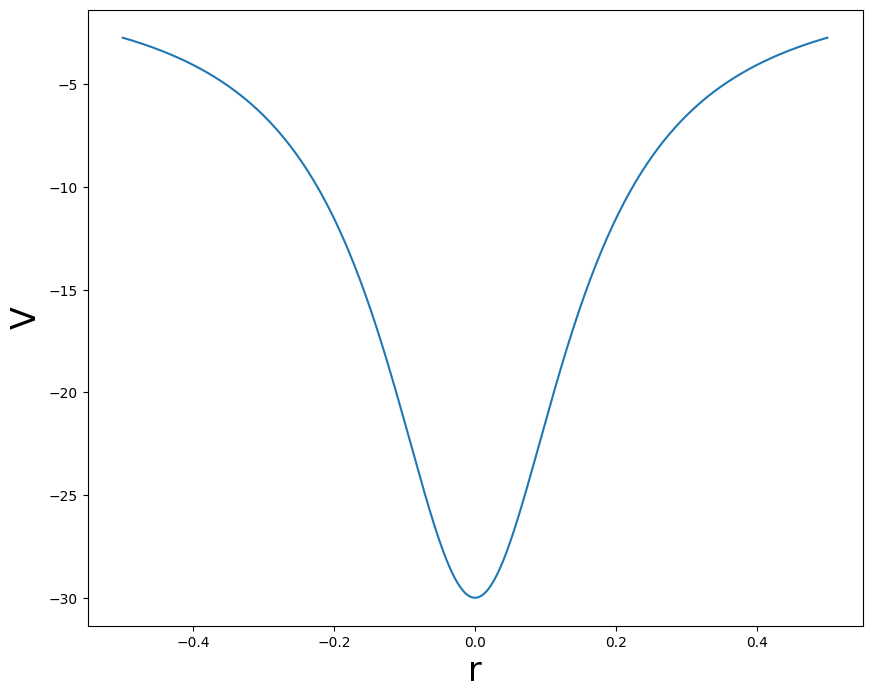

In [12]:
plot.figure(figsize = (10,8))

plot.plot(x.cpu().detach().numpy(),V(grid[:,0],grid[:,1]).reshape(500,500)[:,250])
plot.xlabel('r',fontsize=24)
plot.ylabel('V',fontsize=24)

In [ ]:
savepoint = torch.load('V_0_200066_2_4_384_4_128') #Optional to load a saved model file
nn1.load_state_dict(savepoint['model_state_dict'])

In [13]:
vert = [[0,0],[np.pi,0],[np.pi,np.pi]] #Set up parameters of the k-space sampling
basis = [2*np.pi,2*np.pi]
radius = 1
ibzparams = [vert,basis,radius]

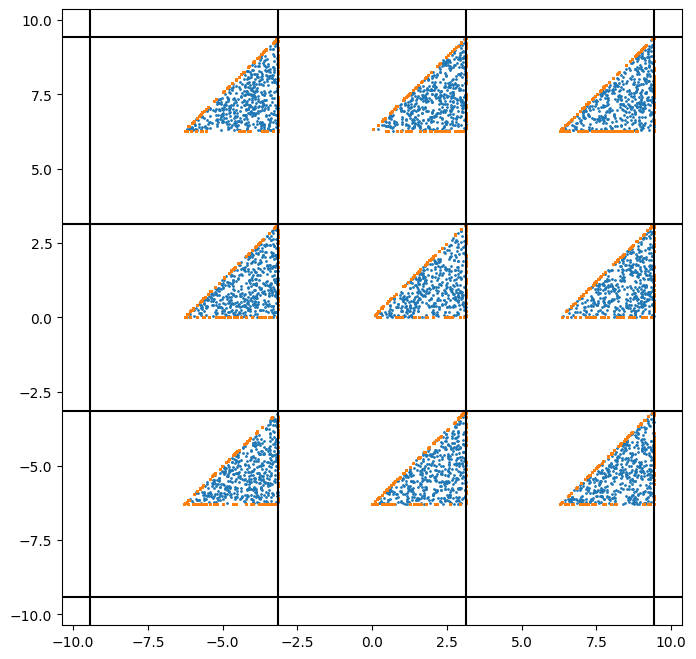

In [14]:

P = IBZ((2**6)**2,vert,basis,radius)
plot.figure(figsize = (8,8)) 
plot.scatter(P[:,0],P[:,1],s=1)

k = wedgepts(250)
k = torch.cat((k,k,k,k,k,k,k,k,k,k,k,k,k,k,k,k),0)
k.requires_grad = True 
W = k.cpu().detach().numpy()

plot.scatter(W[:,0],W[:,1],s=1)
plot.axhline(np.pi,color='black');plot.axhline(-np.pi,color='black');plot.axhline(3*np.pi,color='black');plot.axhline(-3*np.pi,color='black')
plot.axvline(np.pi,color='black');plot.axvline(-np.pi,color='black');plot.axvline(3*np.pi,color='black');plot.axvline(-3*np.pi,color='black')

In [15]:
def resample(npts, device):
    x = (torch.rand((int(npts)))-0.5).to(device) ; y = (torch.rand((int(npts)))-0.5).to(device)
    grid = torch.stack((x,y),1)
    grid.requires_grad = True

    kx = (6*np.pi*torch.rand((int(npts)))-3*np.pi).to(device) ; ky = (6*np.pi*torch.rand((int(npts)))-3*np.pi).to(device)
    k = torch.stack((kx,ky),1)
    k.requires_grad = True
    
    return grid, k

In [16]:
time_start = time.time()
use_scheduler = False
epochs = 5000
npts = 5000

for epoch in range(epochs):
        grid, k = resample(npts, cuda)

        
        Lnorm = 0.0
        
        blochloss = blochLoss(nn1,grid[:,0].reshape(-1,1),grid[:,1].reshape(-1,1),k[:,0].reshape(-1,1),k[:,1].reshape(-1,1),V)
        normloss = normLoss(nn1,ibzparams,V,pts=100,kpts=100)
        bcloss = BCloss(nn1,ibzparams,V,5000)
        
        loss =  blochloss + normloss + bcloss
        
        loss.backward(retain_graph = False)
        
        loss_history.append(loss.cpu().data.numpy())
        bloch_loss_history.append(blochloss.cpu().data.numpy())
        bc_loss_history.append(bcloss.cpu().data.numpy())
        norm_loss_history.append(normloss.cpu().data.numpy())
        
        lr_history.append(optimizer.param_groups[0]["lr"])
        
        
        optimizer.step()
        if len(loss_history) > 10000 and use_scheduler == True:
            scheduler.step()#scheduler.step(loss)
        
        optimizer.zero_grad()
        
        if (len(loss_history)-1)%1000 == 0:
            print('Loss: ' + str(loss_history[-1]) + ' at epoch ' + str(len(loss_history)-1))
            if (epoch+len(loss_history)-1) != 0:
                print('50 Epoch Mean Loss: ' + str(np.array(loss_history[-51:-1]).mean()) + ' at epoch ' + str(len(loss_history)-1))
            print('Runtime: ' + str(round((time.time() - time_start),2)) + ' seconds')
            print(str(round(epoch/(time.time() - time_start),2)) + ' epoch/s')

            
        if len(loss_history)%100000 == 0:
            torch.save({
            'epoch': (len(loss_history)-1),
            'model_state_dict': nn1.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': lossLim,
            'lossHistory': loss_history,
            'lrHistory': lr_history,
            }, 'V_'+str(V0)+'_'+str(len(loss_history)-1)+'_'+str(dims)+'_'+str(f_layers)+'_'+str(f_neurons)+'_'+str(e_layers)+'_'+str(e_neurons))
            
time_end = time.time()
runTime = time_end - time_start
print('Total runtime: ' + str(round(runTime,2)) + ' seconds')
print('Final loss: '+ str(lossLim))
print(str(round(epochs/runTime,2)) + ' epochs/s')

Loss: 103.4299 at epoch 0
Runtime: 1.0 seconds
0.0 epoch/s
Loss: 8.157396 at epoch 1000
50 Epoch Mean Loss: 8.1246 at epoch 1000
Runtime: 523.84 seconds
1.91 epoch/s
Loss: 6.5429697 at epoch 2000
50 Epoch Mean Loss: 6.464168 at epoch 2000
Runtime: 1046.77 seconds
1.91 epoch/s


KeyboardInterrupt: 

Text(76.22631401909722, 0.5, 'Learning Rate')

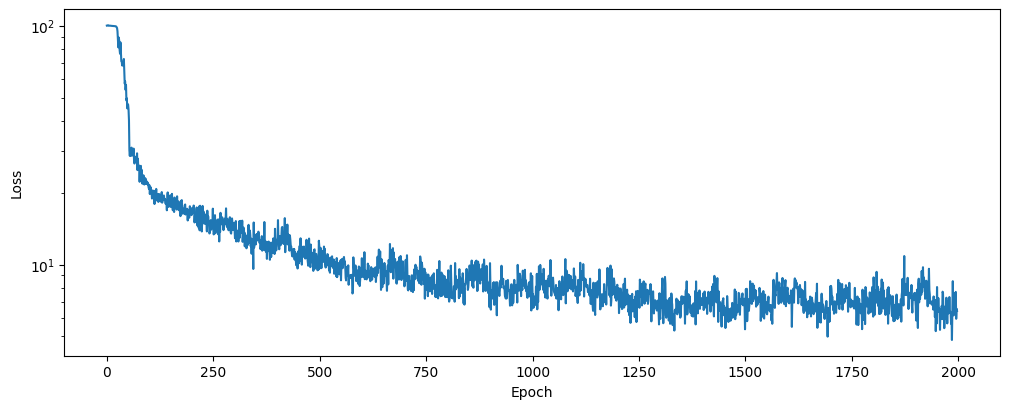

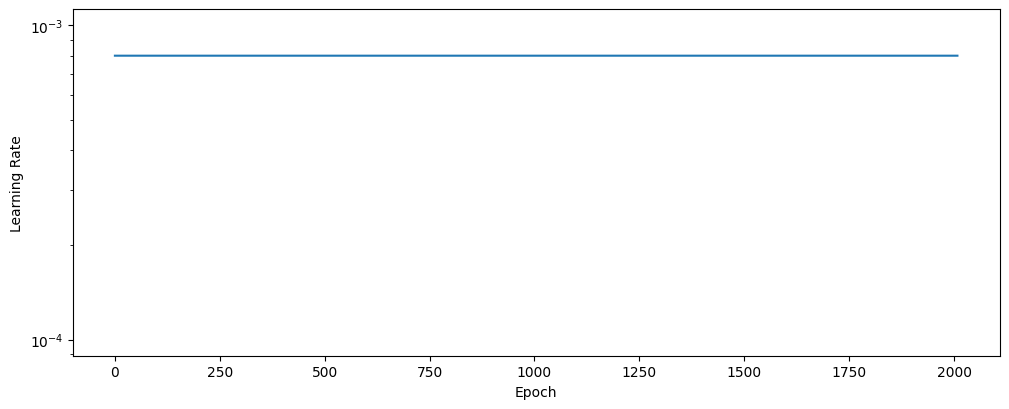

In [17]:
plot.figure(figsize=(10,4))


plot.semilogy(loss_history[10:-1])
plot.tight_layout()
plot.xlabel('Epoch')
plot.ylabel('Loss')

plot.figure(figsize=(10,4))
plot.semilogy(lr_history)
plot.tight_layout()
plot.xlabel('Epoch')
plot.ylabel('Learning Rate')

Text(76.22631401909722, 0.5, 'Loss')

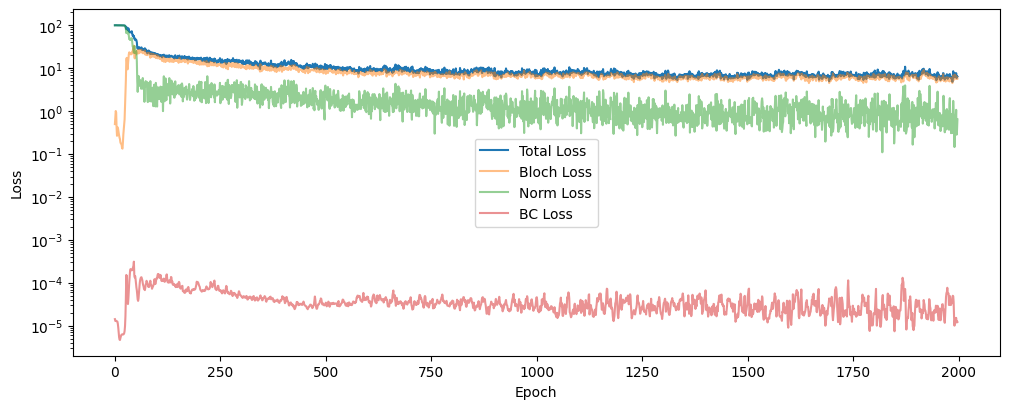

In [18]:
plot.figure(figsize=(10,4))


plot.semilogy(loss_history[10:-1],label='Total Loss')
plot.semilogy(bloch_loss_history[10:-1],alpha=0.5,label='Bloch Loss')
plot.semilogy(norm_loss_history[10:-1],alpha=0.5,label='Norm Loss')
plot.semilogy(bc_loss_history[10:-1],alpha=0.5,label='BC Loss')
plot.tight_layout()
plot.legend()
plot.xlabel('Epoch')
plot.ylabel('Loss')

Text(31.222222222222214, 0.5, 'ky')

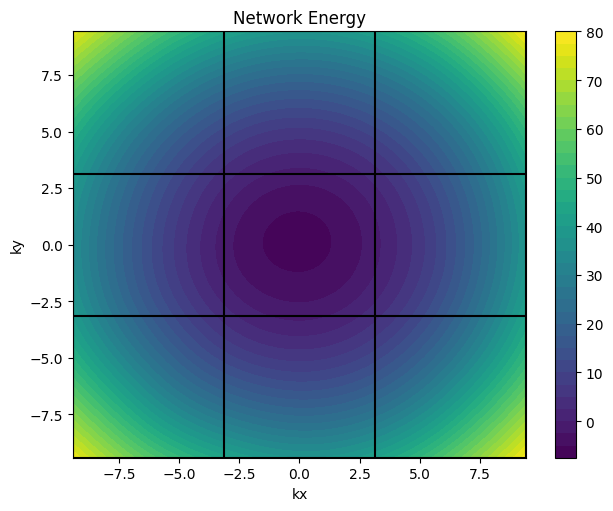

In [21]:
x = torch.linspace(-0.5,0.5,200).to(cuda) ; y = torch.linspace(-0.5,0.5,200).to(cuda)

grid = torch.cartesian_prod(x, y)

kx = torch.linspace(-3*np.pi,3*np.pi,200).to(cuda) ; ky = torch.linspace(-3*np.pi,3*np.pi,200).to(cuda)

k = torch.cartesian_prod(kx, ky)

u,E = nn1(grid[:,0].reshape(-1,1),grid[:,1].reshape(-1,1),k[:,0].reshape(-1,1),k[:,1].reshape(-1,1),V(grid[:,0].reshape(-1,1),grid[:,1].reshape(-1,1)))

plot.contourf(kx.cpu().detach().numpy(),ky.cpu().detach().numpy(),(E).reshape(200,200).cpu().detach().numpy(),40)
plot.tight_layout()
plot.colorbar()

plot.axhline(np.pi,color='black');plot.axhline(-np.pi,color='black');plot.axhline(3*np.pi,color='black');plot.axhline(-3*np.pi,color='black')
plot.axvline(np.pi,color='black');plot.axvline(-np.pi,color='black');plot.axvline(3*np.pi,color='black');plot.axvline(-3*np.pi,color='black')
plot.title('Network Energy')
plot.xlabel('kx')
plot.ylabel('ky')

<>:31: SyntaxWarning: invalid escape sequence '\G'
<>:31: SyntaxWarning: invalid escape sequence '\G'
<>:31: SyntaxWarning: invalid escape sequence '\G'
<>:31: SyntaxWarning: invalid escape sequence '\G'
/tmp/ipykernel_249075/143468624.py:31: SyntaxWarning: invalid escape sequence '\G'
  xlabels = ['$\Gamma$','X','M','$\Gamma$']
/tmp/ipykernel_249075/143468624.py:31: SyntaxWarning: invalid escape sequence '\G'
  xlabels = ['$\Gamma$','X','M','$\Gamma$']


Text(0, 0.5, 'E')

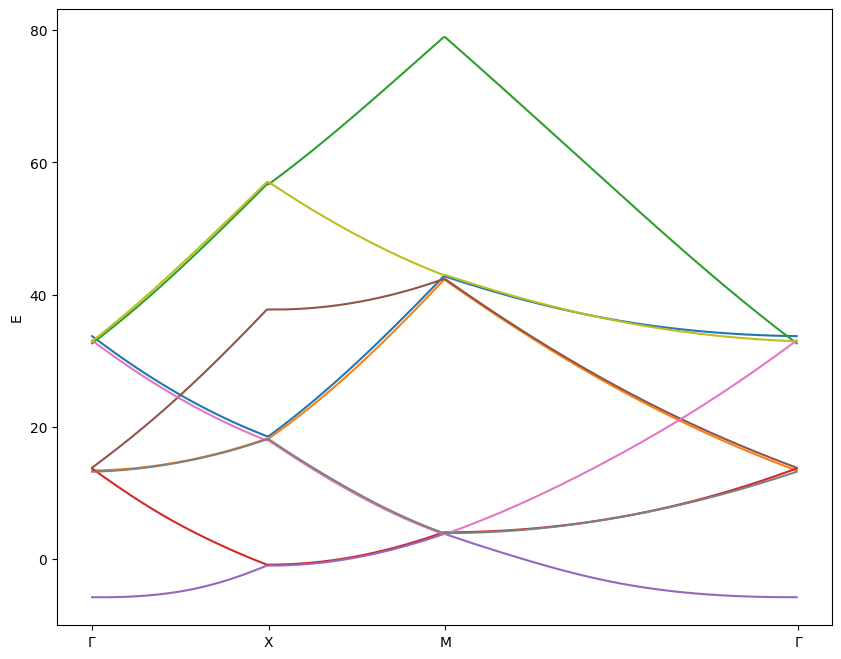

In [23]:
plot.figure(figsize = (10,8))

b1 = 2*np.pi ; b2 = 2*np.pi
sig = [[-1,1],
      [0,1],
      [1,1],
      [-1,0],
      [0,0],
      [1,0],
      [-1,-1],
      [0,-1],
      [1,-1]]

nn = nn1

x = torch.linspace(-0.5,0.5,400).to(cuda) ; y = torch.linspace(-0.5,0.5,400).to(cuda)
kx1 = torch.linspace(0*np.pi,1*np.pi,100).to(cuda) ; kx2 = torch.linspace(1*np.pi,1*np.pi,100).to(cuda) ; kx3 = torch.linspace(1*np.pi,0*np.pi,200).to(cuda)
ky1 = torch.linspace(0,0,100).to(cuda) ; ky2 = torch.linspace(0,1*np.pi,100).to(cuda) ; ky3 = torch.linspace(1*np.pi,0*np.pi,200).to(cuda)
kx = torch.cat((kx1,kx2,kx3),0) ; ky = torch.cat((ky1,ky2,ky3),0)

NNbands = []#np.empty([len(sig)])

for b in range(len(sig)):
    u,E = nn(x.reshape(-1,1),y.reshape(-1,1),(b1*sig[b][0]+kx).reshape(-1,1),(b2*sig[b][1]+ky).reshape(-1,1),V(x.reshape(-1,1),y.reshape(-1,1)))
    NNbands.append(E.cpu().detach().numpy())
    plot.plot(NNbands[b])



xlabelloc = np.array([0,100,200,400])
xlabels = ['$\Gamma$','X','M','$\Gamma$']
plot.xticks(xlabelloc, xlabels)

plot.ylabel('E')

<>:52: SyntaxWarning: invalid escape sequence '\G'
<>:52: SyntaxWarning: invalid escape sequence '\G'
/tmp/ipykernel_249075/3738188752.py:52: SyntaxWarning: invalid escape sequence '\G'
  ax[0,0].set_ylabel('$\Gamma$',fontsize=14)
/home/hsu.circe/.conda/envs/pytorch-geometric/lib/python3.12/site-packages/matplotlib/contour.py:1371: ComplexWarning: Casting complex values to real discards the imaginary part
  self.zmax = z.max().astype(float)
/home/hsu.circe/.conda/envs/pytorch-geometric/lib/python3.12/site-packages/matplotlib/contour.py:1372: ComplexWarning: Casting complex values to real discards the imaginary part
  self.zmin = z.min().astype(float)
/home/hsu.circe/.conda/envs/pytorch-geometric/lib/python3.12/site-packages/numpy/ma/core.py:2820: ComplexWarning: Casting complex values to real discards the imaginary part
  _data = np.array(data, dtype=dtype, copy=copy,


Text(0.5, 0.98, '||u_k||')

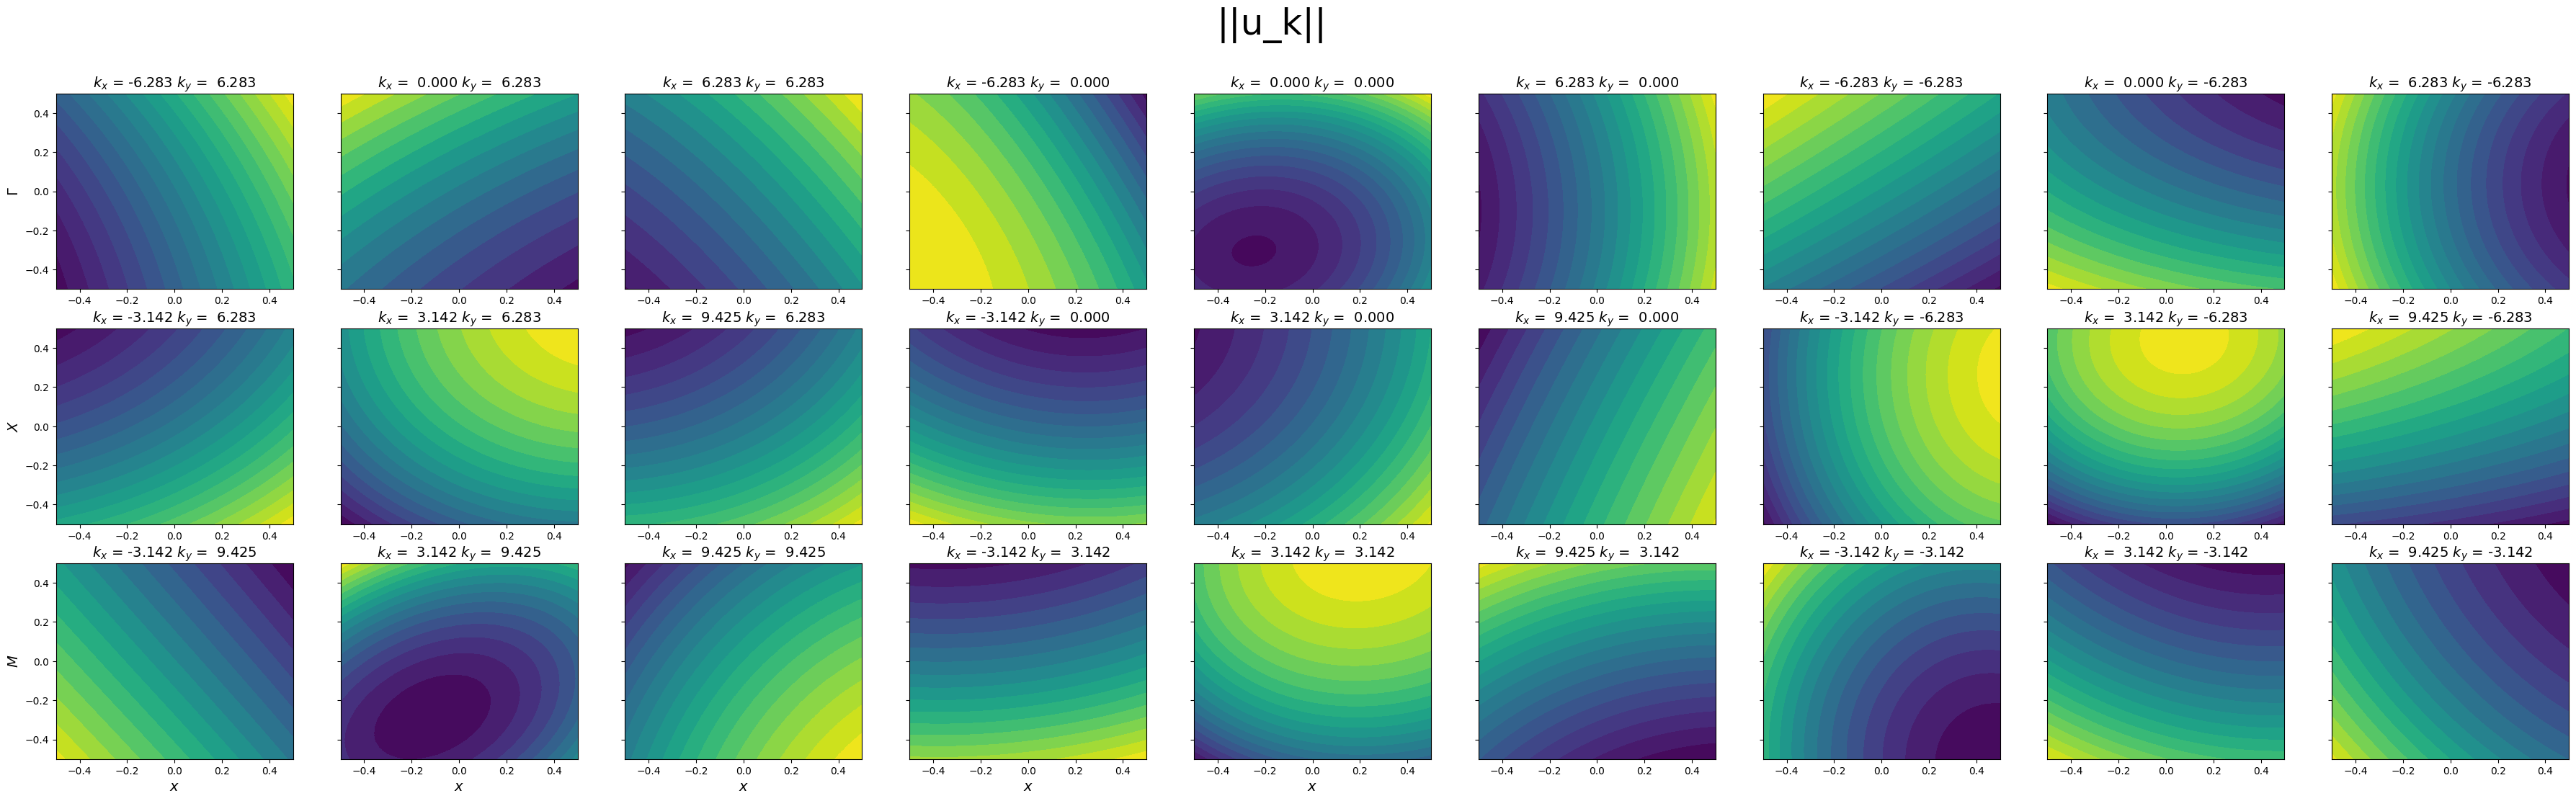

In [24]:
kvals = [
        [0,0],
        [np.pi,0],
        [np.pi,np.pi],
        ]

b = [[2*np.pi,0],[0,2*np.pi]]

knum = len(kvals)
fig, ax = plot.subplots(knum, 9, figsize=(45,4*knum), sharey=True)
xval = np.linspace(-0.5,0.5,200) ; yval = np.linspace(-0.5,0.5,200)
grid = torch.cartesian_prod(torch.linspace(-0.5,0.5,200).to(cuda), torch.linspace(-0.5,0.5,200).to(cuda))
b_1 = b[0][0]+b[1][0]; b_2 = b[0][1]+b[1][1]


for i in range(len(kvals)):

    for n in range(9):
        if n == 0:
            b1 = -1; b2 = 1
        elif n == 1:
            b1 = 0; b2 = 1
        elif n == 2:
            b1 = 1; b2 = 1
        elif n == 3:
            b1 = -1; b2 = 0
        elif n == 4:
            b1 = 0; b2 = 0
        elif n == 5:
            b1 = 1; b2 = 0
        elif n == 6:
            b1 = -1; b2 = -1
        elif n == 7:
            b1 = 0; b2 = -1
        elif n == 8:
            b1 = 1; b2 = -1
            
        k_x = b1*b_1 + kvals[i][0] ; k_y = b2*b_2 + kvals[i][1]
        k = torch.cartesian_prod(torch.linspace(k_x,k_x,200).to(cuda), torch.linspace(k_y,k_y,200).to(cuda))
        u,E = nn1(grid[:,0].reshape(-1,1),grid[:,1].reshape(-1,1),k[:,0].reshape(-1,1),k[:,1].reshape(-1,1),V(grid[:,0].reshape(-1,1),grid[:,1].reshape(-1,1)))        
        
        u = torch.complex(u[:,0],u[:,1])
        
        #ax[i,n].contourf(xval,yval,(u[:,0]**2+u[:,1]**2).reshape(200,200).cpu().detach().numpy(),20)#ax[i,n].contourf(xval,yval,(u[:,0]**2+u[:,1]**2).reshape(200,200).cpu().detach().numpy(),20)
        ax[i,n].contourf(xval,yval,(u*u.conj()).reshape(200,200).cpu().detach().numpy(),20)#ax[i,n].contourf(xval,yval,(u[:,0]**2+u[:,1]**2).reshape(200,200).cpu().detach().numpy(),20)

        ax[i,n].set_xlim(-0.5,0.5)
        ax[i,n].set_ylim(-0.5,0.5)
        ax[i,n].set_title('$k_x$ = {:6.3f}'.format(k_x) + ' $k_y$ = {:6.3f}'.format(k_y),fontsize=14)
for i in range(5):
    ax[-1,i].set_xlabel('$x$',fontsize=14)
ax[0,0].set_ylabel('$\Gamma$',fontsize=14)
ax[1,0].set_ylabel('$X$',fontsize=14)
ax[2,0].set_ylabel('$M$',fontsize=14)
fig.suptitle('||u_k||',fontsize=36)

<>:48: SyntaxWarning: invalid escape sequence '\G'
<>:48: SyntaxWarning: invalid escape sequence '\G'
/tmp/ipykernel_249075/3473955016.py:48: SyntaxWarning: invalid escape sequence '\G'
  ax[0,0].set_ylabel('$\Gamma$',fontsize=14)


Text(0.5, 0.98, 'u_k real')

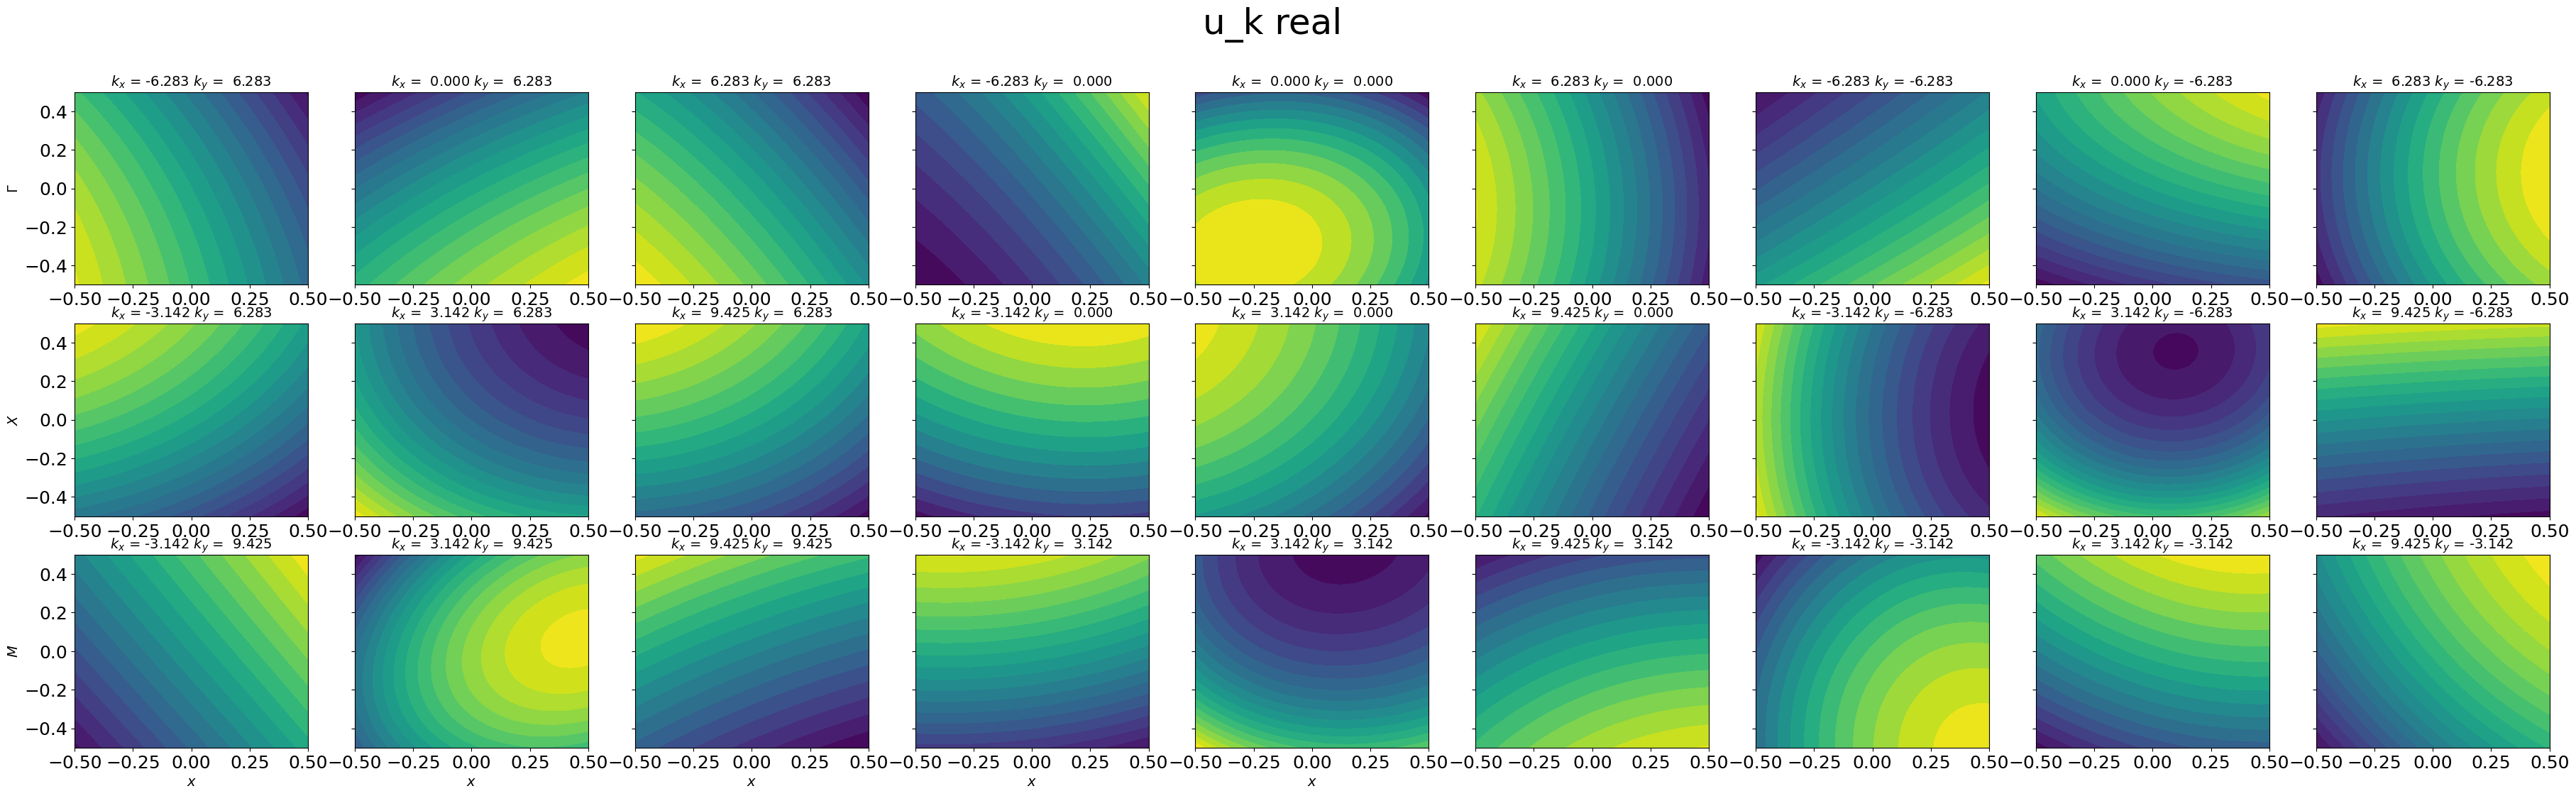

In [26]:
kvals = [
        [0,0],
        [np.pi,0],
        [np.pi,np.pi],
        ]

b = [[2*np.pi,0],[0,2*np.pi]]

knum = len(kvals)
fig, ax = plot.subplots(knum, 9, figsize=(45,4*knum), sharey=True)
xval = np.linspace(-0.5,0.5,200) ; yval = np.linspace(-0.5,0.5,200)
grid = torch.cartesian_prod(torch.linspace(-0.5,0.5,200).to(cuda), torch.linspace(-0.5,0.5,200).to(cuda))
b_1 = b[0][0]+b[1][0]; b_2 = b[0][1]+b[1][1]


for i in range(len(kvals)):

    for n in range(9):
        if n == 0:
            b1 = -1; b2 = 1
        elif n == 1:
            b1 = 0; b2 = 1
        elif n == 2:
            b1 = 1; b2 = 1
        elif n == 3:
            b1 = -1; b2 = 0
        elif n == 4:
            b1 = 0; b2 = 0
        elif n == 5:
            b1 = 1; b2 = 0
        elif n == 6:
            b1 = -1; b2 = -1
        elif n == 7:
            b1 = 0; b2 = -1
        elif n == 8:
            b1 = 1; b2 = -1
            
        k_x = b1*b_1 + kvals[i][0] ; k_y = b2*b_2 + kvals[i][1]
        k = torch.cartesian_prod(torch.linspace(k_x,k_x,200).to(cuda), torch.linspace(k_y,k_y,200).to(cuda))
        u,E = nn1(grid[:,0].reshape(-1,1),grid[:,1].reshape(-1,1),k[:,0].reshape(-1,1),k[:,1].reshape(-1,1),V(grid[:,0].reshape(-1,1),grid[:,1].reshape(-1,1)))        
        
        ax[i,n].contourf(xval,yval,(u[:,0]).reshape(200,200).cpu().detach().numpy(),20)#ax[i,n].contourf(xval,yval,(u[:,0]**2+u[:,1]**2).reshape(200,200).cpu().detach().numpy(),20)
        ax[i,n].set_xlim(-0.5,0.5)
        ax[i,n].set_ylim(-0.5,0.5)
        ax[i,n].set_title('$k_x$ = {:6.3f}'.format(k_x) + ' $k_y$ = {:6.3f}'.format(k_y),fontsize=14)
for i in range(5):
    ax[-1,i].set_xlabel('$x$',fontsize=14)
ax[0,0].set_ylabel('$\Gamma$',fontsize=14)
ax[1,0].set_ylabel('$X$',fontsize=14)
ax[2,0].set_ylabel('$M$',fontsize=14)
fig.suptitle('u_k real',fontsize=36)

<>:48: SyntaxWarning: invalid escape sequence '\G'
<>:48: SyntaxWarning: invalid escape sequence '\G'
/tmp/ipykernel_249075/3491102757.py:48: SyntaxWarning: invalid escape sequence '\G'
  ax[0,0].set_ylabel('$\Gamma$',fontsize=14)


Text(0.5, 0.98, 'u_k imaginary')

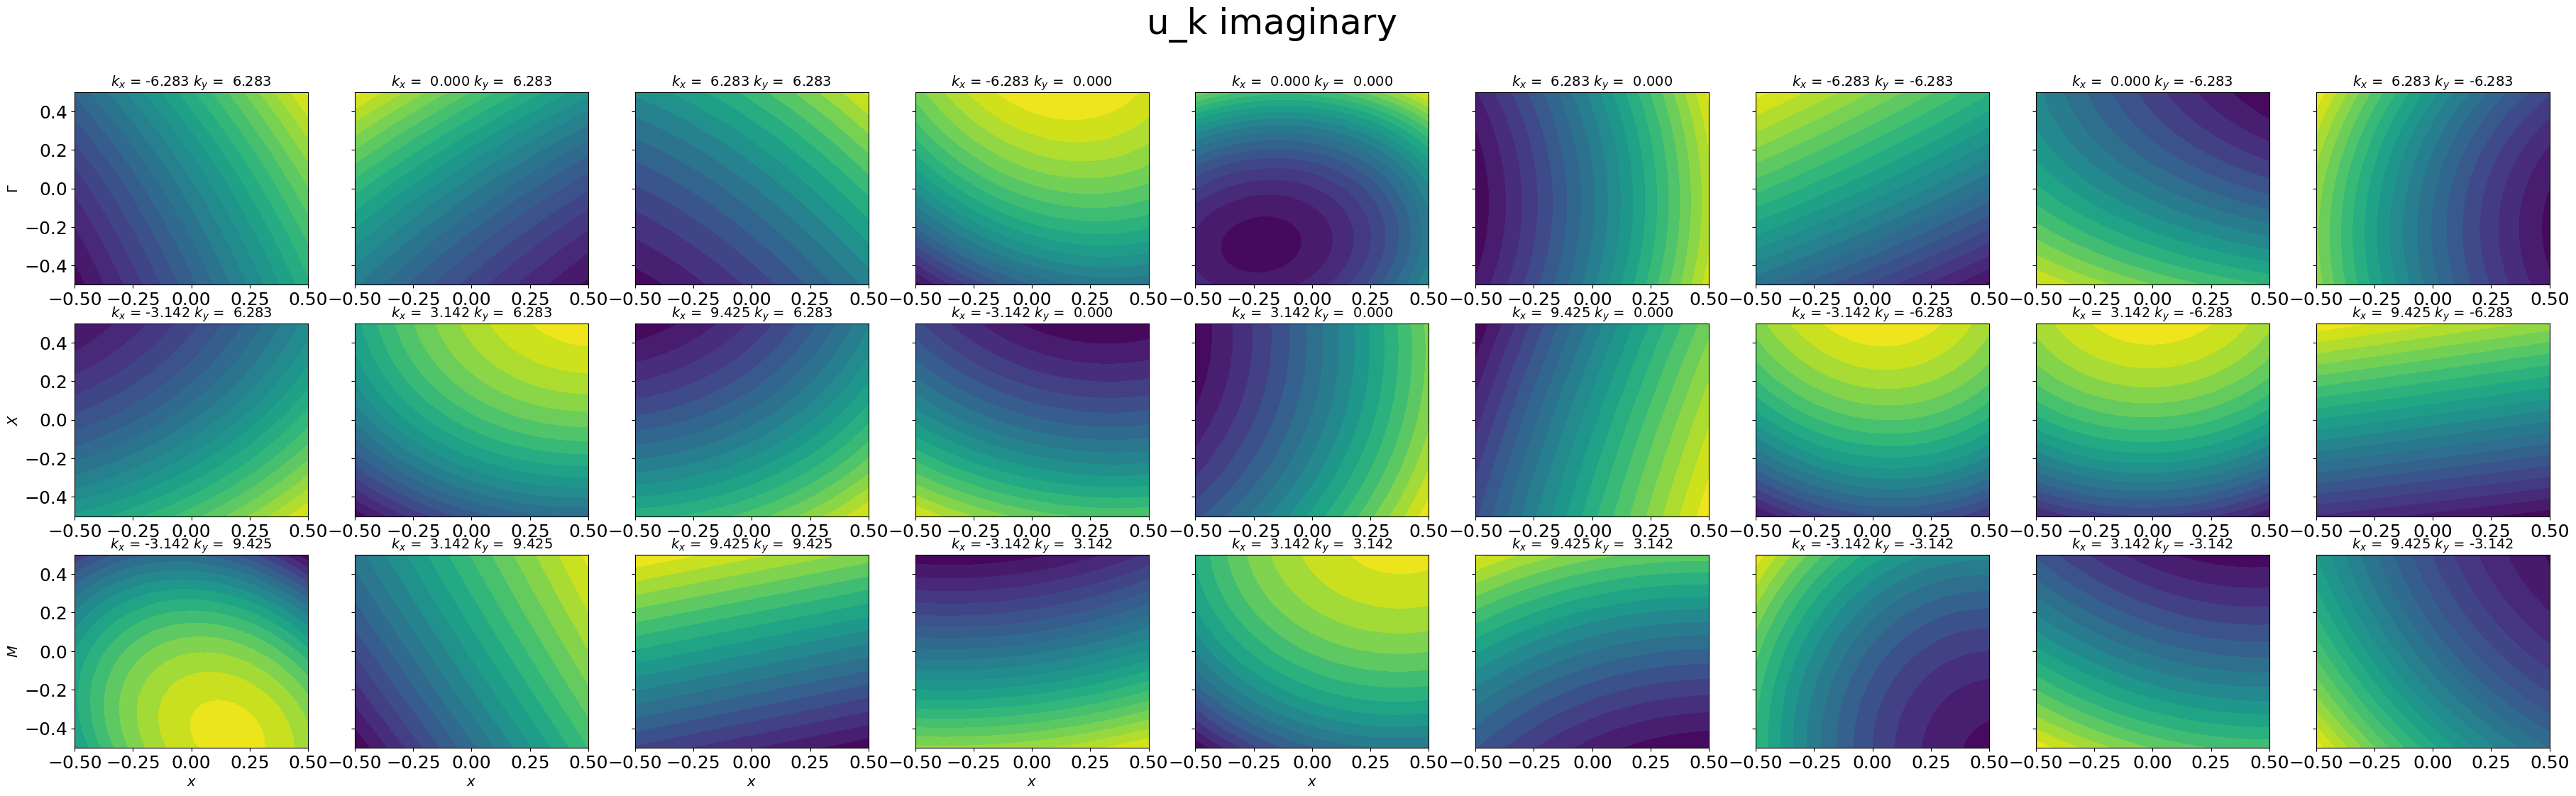

In [27]:
kvals = [
        [0,0],
        [np.pi,0],
        [np.pi,np.pi],
        ]

b = [[2*np.pi,0],[0,2*np.pi]]

knum = len(kvals)
fig, ax = plot.subplots(knum, 9, figsize=(45,4*knum), sharey=True)
xval = np.linspace(-0.5,0.5,200) ; yval = np.linspace(-0.5,0.5,200)
grid = torch.cartesian_prod(torch.linspace(-0.5,0.5,200).to(cuda), torch.linspace(-0.5,0.5,200).to(cuda))
b_1 = b[0][0]+b[1][0]; b_2 = b[0][1]+b[1][1]


for i in range(len(kvals)):

    for n in range(9):
        if n == 0:
            b1 = -1; b2 = 1
        elif n == 1:
            b1 = 0; b2 = 1
        elif n == 2:
            b1 = 1; b2 = 1
        elif n == 3:
            b1 = -1; b2 = 0
        elif n == 4:
            b1 = 0; b2 = 0
        elif n == 5:
            b1 = 1; b2 = 0
        elif n == 6:
            b1 = -1; b2 = -1
        elif n == 7:
            b1 = 0; b2 = -1
        elif n == 8:
            b1 = 1; b2 = -1
            
        k_x = b1*b_1 + kvals[i][0] ; k_y = b2*b_2 + kvals[i][1]
        k = torch.cartesian_prod(torch.linspace(k_x,k_x,200).to(cuda), torch.linspace(k_y,k_y,200).to(cuda))
        u,E = nn1(grid[:,0].reshape(-1,1),grid[:,1].reshape(-1,1),k[:,0].reshape(-1,1),k[:,1].reshape(-1,1),V(grid[:,0].reshape(-1,1),grid[:,1].reshape(-1,1)))        
        
        ax[i,n].contourf(xval,yval,(u[:,1]).reshape(200,200).cpu().detach().numpy(),20)#ax[i,n].contourf(xval,yval,(u[:,0]**2+u[:,1]**2).reshape(200,200).cpu().detach().numpy(),20)
        ax[i,n].set_xlim(-0.5,0.5)
        ax[i,n].set_ylim(-0.5,0.5)
        ax[i,n].set_title('$k_x$ = {:6.3f}'.format(k_x) + ' $k_y$ = {:6.3f}'.format(k_y),fontsize=14)
for i in range(5):
    ax[-1,i].set_xlabel('$x$',fontsize=14)
ax[0,0].set_ylabel('$\Gamma$',fontsize=14)
ax[1,0].set_ylabel('$X$',fontsize=14)
ax[2,0].set_ylabel('$M$',fontsize=14)
fig.suptitle('u_k imaginary',fontsize=36)

<>:53: SyntaxWarning: invalid escape sequence '\G'
<>:56: SyntaxWarning: invalid escape sequence '\P'
<>:53: SyntaxWarning: invalid escape sequence '\G'
<>:56: SyntaxWarning: invalid escape sequence '\P'
/tmp/ipykernel_249075/3581277811.py:53: SyntaxWarning: invalid escape sequence '\G'
  ax[0,0].set_ylabel('$\Gamma$',fontsize=14)
/tmp/ipykernel_249075/3581277811.py:56: SyntaxWarning: invalid escape sequence '\P'
  fig.suptitle('$\Psi$ real',fontsize=36)


Text(0.5, 0.98, '$\\Psi$ real')

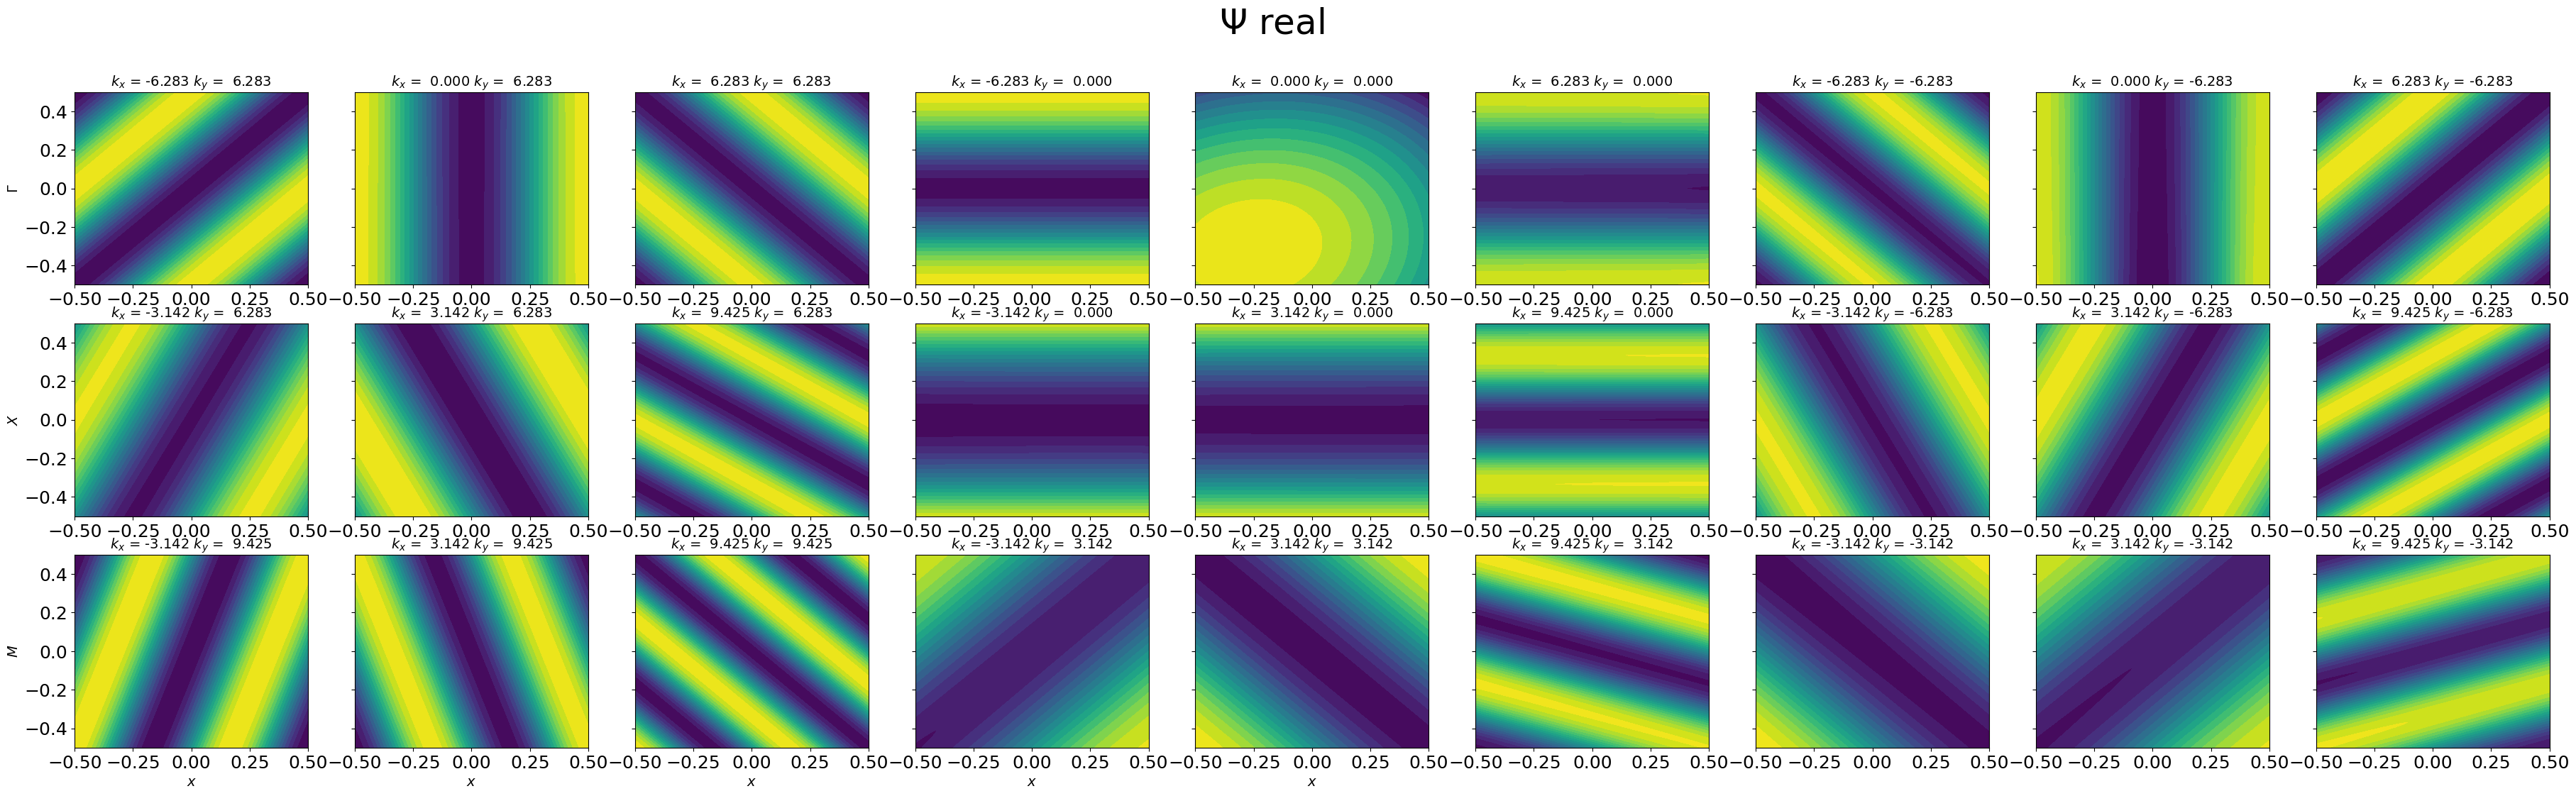

In [28]:
kvals = [
        [0,0],
        [np.pi,0],
        [np.pi,np.pi],
        ]

b = [[2*np.pi,0],[0,2*np.pi]]

knum = len(kvals)
fig, ax = plot.subplots(knum, 9, figsize=(45,4*knum), sharey=True)
xval = np.linspace(-0.5,0.5,200) ; yval = np.linspace(-0.5,0.5,200)
grid = torch.cartesian_prod(torch.linspace(-0.5,0.5,200).to(cuda), torch.linspace(-0.5,0.5,200).to(cuda))
b_1 = b[0][0]+b[1][0]; b_2 = b[0][1]+b[1][1]


for i in range(len(kvals)):

    for n in range(9):
        if n == 0:
            b1 = -1; b2 = 1
        elif n == 1:
            b1 = 0; b2 = 1
        elif n == 2:
            b1 = 1; b2 = 1
        elif n == 3:
            b1 = -1; b2 = 0
        elif n == 4:
            b1 = 0; b2 = 0
        elif n == 5:
            b1 = 1; b2 = 0
        elif n == 6:
            b1 = -1; b2 = -1
        elif n == 7:
            b1 = 0; b2 = -1
        elif n == 8:
            b1 = 1; b2 = -1
            
        k_x = b1*b_1 + kvals[i][0] ; k_y = b2*b_2 + kvals[i][1]
        k = torch.cartesian_prod(torch.linspace(k_x,k_x,200).to(cuda), torch.linspace(k_y,k_y,200).to(cuda))
        u,E = nn1(grid[:,0].reshape(-1,1),grid[:,1].reshape(-1,1),k[:,0].reshape(-1,1),k[:,1].reshape(-1,1),V(grid[:,0].reshape(-1,1),grid[:,1].reshape(-1,1)))        
        
        k_r_dot = k_x*grid[:,0].reshape(-1,1) + k_y*grid[:,1].reshape(-1,1)
        psi_real = torch.cos(k_r_dot).reshape(-1,1)*u[:,0].reshape(-1,1)
        
        
        
        ax[i,n].contourf(xval,yval,(psi_real).reshape(200,200).cpu().detach().numpy(),20)#ax[i,n].contourf(xval,yval,(u[:,0]**2+u[:,1]**2).reshape(200,200).cpu().detach().numpy(),20)
        ax[i,n].set_xlim(-0.5,0.5)
        ax[i,n].set_ylim(-0.5,0.5)
        ax[i,n].set_title('$k_x$ = {:6.3f}'.format(k_x) + ' $k_y$ = {:6.3f}'.format(k_y),fontsize=14)
for i in range(5):
    ax[-1,i].set_xlabel('$x$',fontsize=14)
ax[0,0].set_ylabel('$\Gamma$',fontsize=14)
ax[1,0].set_ylabel('$X$',fontsize=14)
ax[2,0].set_ylabel('$M$',fontsize=14)
fig.suptitle('$\Psi$ real',fontsize=36)

<>:53: SyntaxWarning: invalid escape sequence '\G'
<>:56: SyntaxWarning: invalid escape sequence '\P'
<>:53: SyntaxWarning: invalid escape sequence '\G'
<>:56: SyntaxWarning: invalid escape sequence '\P'
/tmp/ipykernel_249075/637040175.py:53: SyntaxWarning: invalid escape sequence '\G'
  ax[0,0].set_ylabel('$\Gamma$',fontsize=14)
/tmp/ipykernel_249075/637040175.py:56: SyntaxWarning: invalid escape sequence '\P'
  fig.suptitle('$\Psi$ imaginary',fontsize=36)


Text(0.5, 0.98, '$\\Psi$ imaginary')

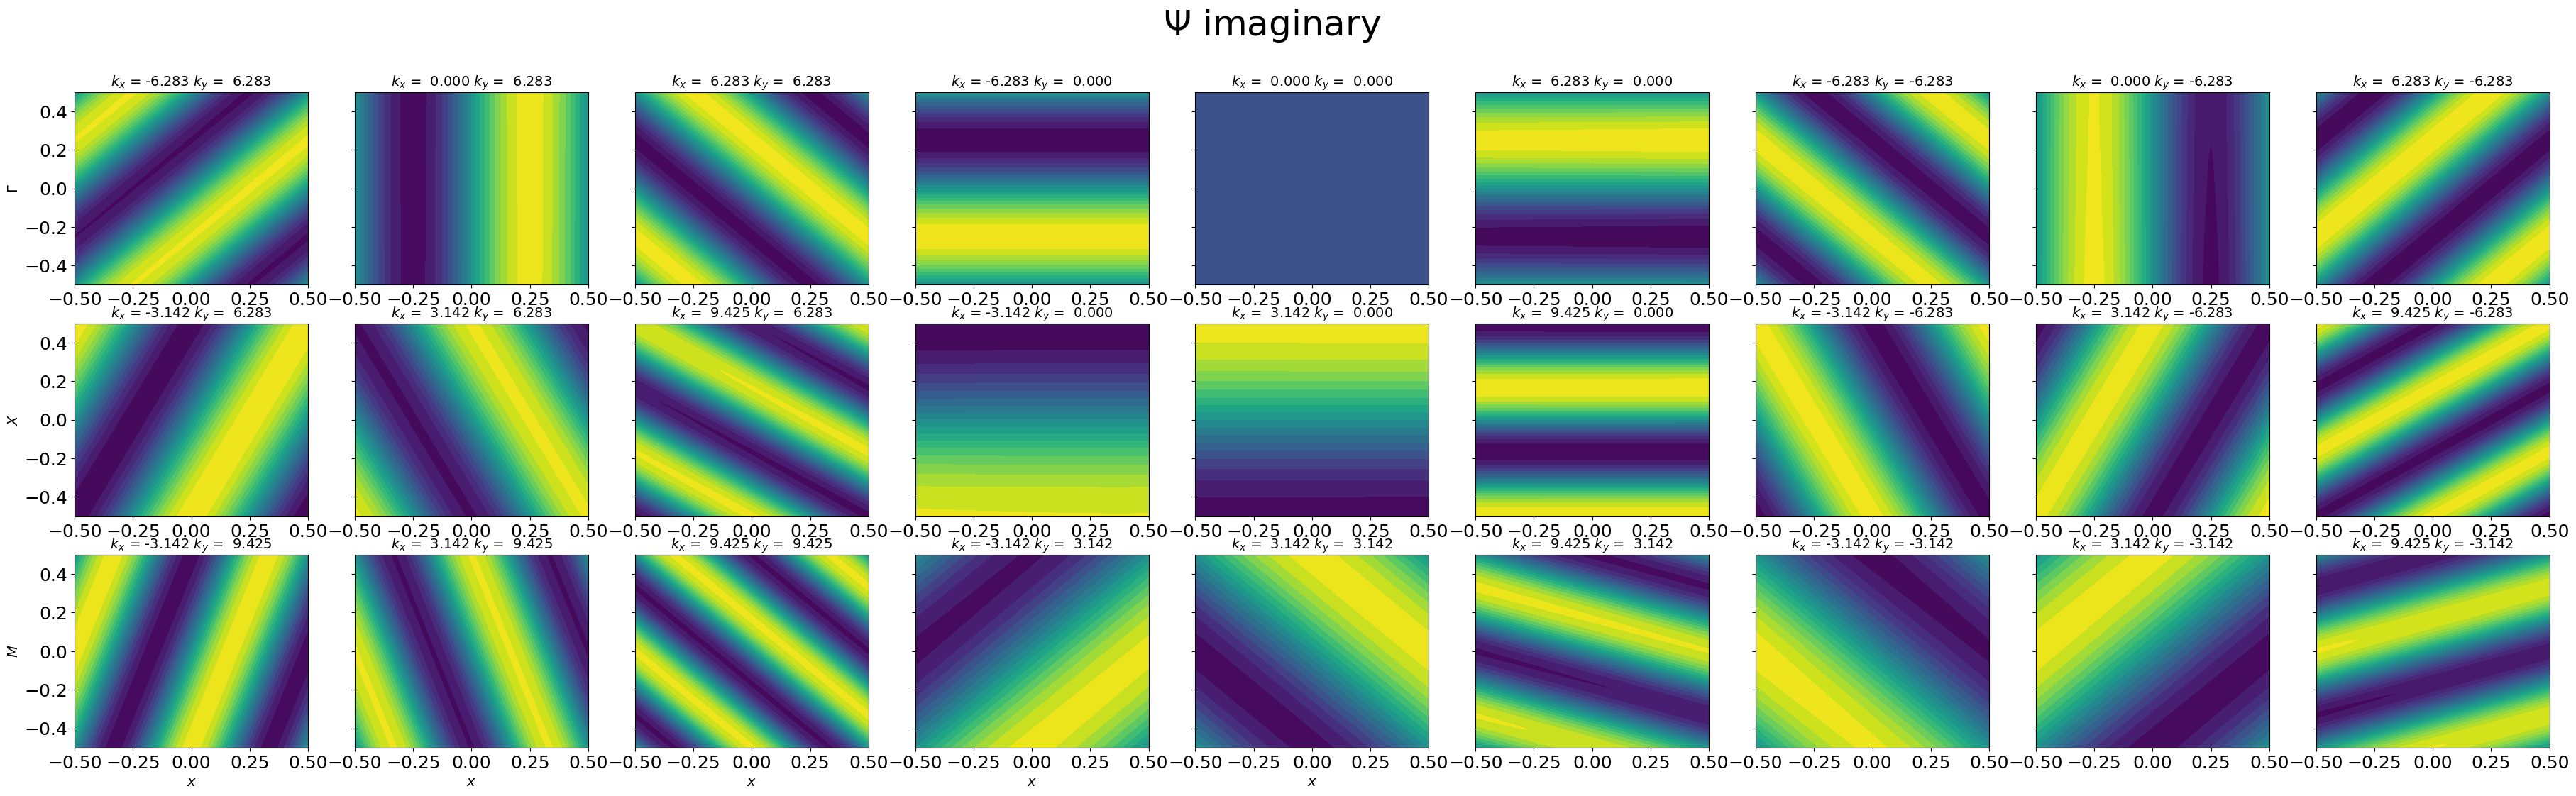

In [29]:
kvals = [
        [0,0],
        [np.pi,0],
        [np.pi,np.pi],
        ]

b = [[2*np.pi,0],[0,2*np.pi]]

knum = len(kvals)
fig, ax = plot.subplots(knum, 9, figsize=(45,4*knum), sharey=True)
xval = np.linspace(-0.5,0.5,200) ; yval = np.linspace(-0.5,0.5,200)
grid = torch.cartesian_prod(torch.linspace(-0.5,0.5,200).to(cuda), torch.linspace(-0.5,0.5,200).to(cuda))
b_1 = b[0][0]+b[1][0]; b_2 = b[0][1]+b[1][1]


for i in range(len(kvals)):

    for n in range(9):
        if n == 0:
            b1 = -1; b2 = 1
        elif n == 1:
            b1 = 0; b2 = 1
        elif n == 2:
            b1 = 1; b2 = 1
        elif n == 3:
            b1 = -1; b2 = 0
        elif n == 4:
            b1 = 0; b2 = 0
        elif n == 5:
            b1 = 1; b2 = 0
        elif n == 6:
            b1 = -1; b2 = -1
        elif n == 7:
            b1 = 0; b2 = -1
        elif n == 8:
            b1 = 1; b2 = -1
            
        k_x = b1*b_1 + kvals[i][0] ; k_y = b2*b_2 + kvals[i][1]
        k = torch.cartesian_prod(torch.linspace(k_x,k_x,200).to(cuda), torch.linspace(k_y,k_y,200).to(cuda))
        u,E = nn1(grid[:,0].reshape(-1,1),grid[:,1].reshape(-1,1),k[:,0].reshape(-1,1),k[:,1].reshape(-1,1),V(grid[:,0].reshape(-1,1),grid[:,1].reshape(-1,1)))        
        
        k_r_dot = k_x*grid[:,0].reshape(-1,1) + k_y*grid[:,1].reshape(-1,1)
        psi_im = torch.sin(k_r_dot).reshape(-1,1)*u[:,1].reshape(-1,1)
        
        
        
        ax[i,n].contourf(xval,yval,(psi_im).reshape(200,200).cpu().detach().numpy(),20)#ax[i,n].contourf(xval,yval,(u[:,0]**2+u[:,1]**2).reshape(200,200).cpu().detach().numpy(),20)
        ax[i,n].set_xlim(-0.5,0.5)
        ax[i,n].set_ylim(-0.5,0.5)
        ax[i,n].set_title('$k_x$ = {:6.3f}'.format(k_x) + ' $k_y$ = {:6.3f}'.format(k_y),fontsize=14)
for i in range(5):
    ax[-1,i].set_xlabel('$x$',fontsize=14)
ax[0,0].set_ylabel('$\Gamma$',fontsize=14)
ax[1,0].set_ylabel('$X$',fontsize=14)
ax[2,0].set_ylabel('$M$',fontsize=14)
fig.suptitle('$\Psi$ imaginary',fontsize=36)

<>:55: SyntaxWarning: invalid escape sequence '\G'
<>:58: SyntaxWarning: invalid escape sequence '\P'
<>:55: SyntaxWarning: invalid escape sequence '\G'
<>:58: SyntaxWarning: invalid escape sequence '\P'
/tmp/ipykernel_249075/342631846.py:55: SyntaxWarning: invalid escape sequence '\G'
  ax[0,0].set_ylabel('$\Gamma$',fontsize=14)
/tmp/ipykernel_249075/342631846.py:58: SyntaxWarning: invalid escape sequence '\P'
  fig.suptitle('||$\Psi$||',fontsize=36)


Text(0.5, 0.98, '||$\\Psi$||')

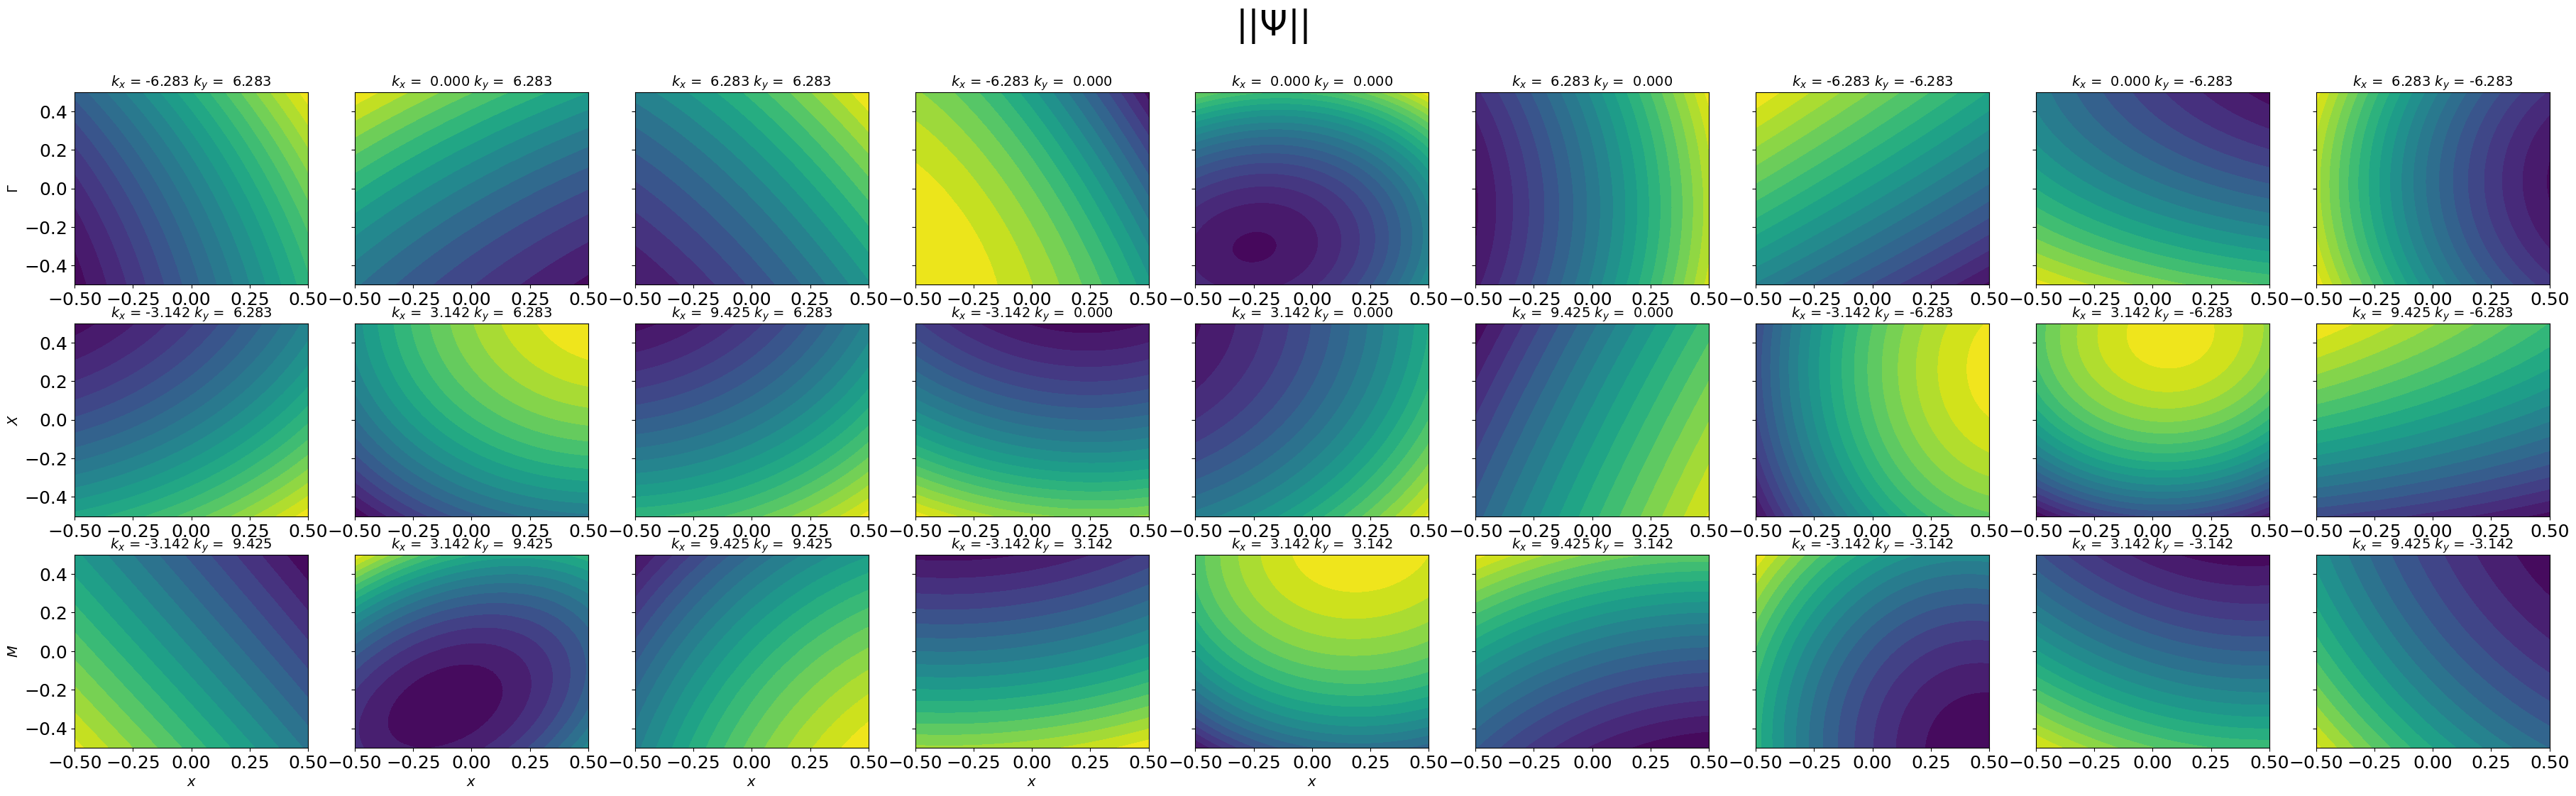

In [30]:
kvals = [
        [0,0],
        [np.pi,0],
        [np.pi,np.pi],
        ]

b = [[2*np.pi,0],[0,2*np.pi]]

knum = len(kvals)
fig, ax = plot.subplots(knum, 9, figsize=(45,4*knum), sharey=True)
xval = np.linspace(-0.5,0.5,200) ; yval = np.linspace(-0.5,0.5,200)
grid = torch.cartesian_prod(torch.linspace(-0.5,0.5,200).to(cuda), torch.linspace(-0.5,0.5,200).to(cuda))
b_1 = b[0][0]+b[1][0]; b_2 = b[0][1]+b[1][1]


for i in range(len(kvals)):

    for n in range(9):
        if n == 0:
            b1 = -1; b2 = 1
        elif n == 1:
            b1 = 0; b2 = 1
        elif n == 2:
            b1 = 1; b2 = 1
        elif n == 3:
            b1 = -1; b2 = 0
        elif n == 4:
            b1 = 0; b2 = 0
        elif n == 5:
            b1 = 1; b2 = 0
        elif n == 6:
            b1 = -1; b2 = -1
        elif n == 7:
            b1 = 0; b2 = -1
        elif n == 8:
            b1 = 1; b2 = -1
            
        k_x = b1*b_1 + kvals[i][0] ; k_y = b2*b_2 + kvals[i][1]
        k = torch.cartesian_prod(torch.linspace(k_x,k_x,200).to(cuda), torch.linspace(k_y,k_y,200).to(cuda))
        u,E = nn1(grid[:,0].reshape(-1,1),grid[:,1].reshape(-1,1),k[:,0].reshape(-1,1),k[:,1].reshape(-1,1),V(grid[:,0].reshape(-1,1),grid[:,1].reshape(-1,1)))        
        
        k_r_dot = k_x*grid[:,0].reshape(-1,1) + k_y*grid[:,1].reshape(-1,1)
        psi_real = u[:,0].reshape(-1,1)*torch.cos(k_r_dot).reshape(-1,1)-u[:,1].reshape(-1,1)*torch.sin(k_r_dot).reshape(-1,1)
        psi_im = u[:,0].reshape(-1,1)*torch.sin(k_r_dot).reshape(-1,1)+u[:,1].reshape(-1,1)*torch.cos(k_r_dot).reshape(-1,1)
        
        psi = torch.complex(psi_real,psi_im)
        
        
        ax[i,n].contourf(xval,yval,(psi*psi.conj()).reshape(200,200).cpu().detach().numpy(),20)#ax[i,n].contourf(xval,yval,(u[:,0]**2+u[:,1]**2).reshape(200,200).cpu().detach().numpy(),20)
        ax[i,n].set_xlim(-0.5,0.5)
        ax[i,n].set_ylim(-0.5,0.5)
        ax[i,n].set_title('$k_x$ = {:6.3f}'.format(k_x) + ' $k_y$ = {:6.3f}'.format(k_y),fontsize=14)
for i in range(5):
    ax[-1,i].set_xlabel('$x$',fontsize=14)
ax[0,0].set_ylabel('$\Gamma$',fontsize=14)
ax[1,0].set_ylabel('$X$',fontsize=14)
ax[2,0].set_ylabel('$M$',fontsize=14)
fig.suptitle('||$\Psi$||',fontsize=36)

In [ ]:
kvals = [
        [0,0],
        [np.pi,0],
        [np.pi,np.pi],
        ]

b = [[2*np.pi,0],[0,2*np.pi]]

knum = len(kvals)
fig, ax = plot.subplots(knum, 9, figsize=(45,4*knum), sharey=True)
xval = np.linspace(-0.5,0.5,200) ; yval = np.linspace(-0.5,0.5,200)
grid = torch.cartesian_prod(torch.linspace(-0.5,0.5,200).to(cuda), torch.linspace(-0.5,0.5,200).to(cuda))
b_1 = b[0][0]+b[1][0]; b_2 = b[0][1]+b[1][1]


for i in range(len(kvals)):

    for n in range(9):
        if n == 0:
            b1 = -1; b2 = 1
        elif n == 1:
            b1 = 0; b2 = 1
        elif n == 2:
            b1 = 1; b2 = 1
        elif n == 3:
            b1 = -1; b2 = 0
        elif n == 4:
            b1 = 0; b2 = 0
        elif n == 5:
            b1 = 1; b2 = 0
        elif n == 6:
            b1 = -1; b2 = -1
        elif n == 7:
            b1 = 0; b2 = -1
        elif n == 8:
            b1 = 1; b2 = -1
            
        k_x = b1*b_1 + kvals[i][0] ; k_y = b2*b_2 + kvals[i][1]
        k = torch.cartesian_prod(torch.linspace(k_x,k_x,200).to(cuda), torch.linspace(k_y,k_y,200).to(cuda))
        u,E = nn1(grid[:,0].reshape(-1,1),grid[:,1].reshape(-1,1),k[:,0].reshape(-1,1),k[:,1].reshape(-1,1),V(grid[:,0].reshape(-1,1),grid[:,1].reshape(-1,1)))        
        
        k_r_dot = k_x*grid[:,0].reshape(-1,1) + k_y*grid[:,1].reshape(-1,1)
        psi_real = torch.cos(k_r_dot).reshape(-1,1)
        psi_im = torch.sin(k_r_dot).reshape(-1,1)
        
        psi = torch.complex(psi_real,psi_im)
        
        
        ax[i,n].contourf(xval,yval,(psi*psi.conj()).reshape(200,200).cpu().detach().numpy(),20)#ax[i,n].contourf(xval,yval,(u[:,0]**2+u[:,1]**2).reshape(200,200).cpu().detach().numpy(),20)
        ax[i,n].set_xlim(-0.5,0.5)
        ax[i,n].set_ylim(-0.5,0.5)
        ax[i,n].set_title('$k_x$ = {:6.3f}'.format(k_x) + ' $k_y$ = {:6.3f}'.format(k_y),fontsize=14)
for i in range(5):
    ax[-1,i].set_xlabel('$x$',fontsize=14)
ax[0,0].set_ylabel('$\Gamma$',fontsize=14)
ax[1,0].set_ylabel('$X$',fontsize=14)
ax[2,0].set_ylabel('$M$',fontsize=14)
fig.suptitle('Plane Waves',fontsize=36)

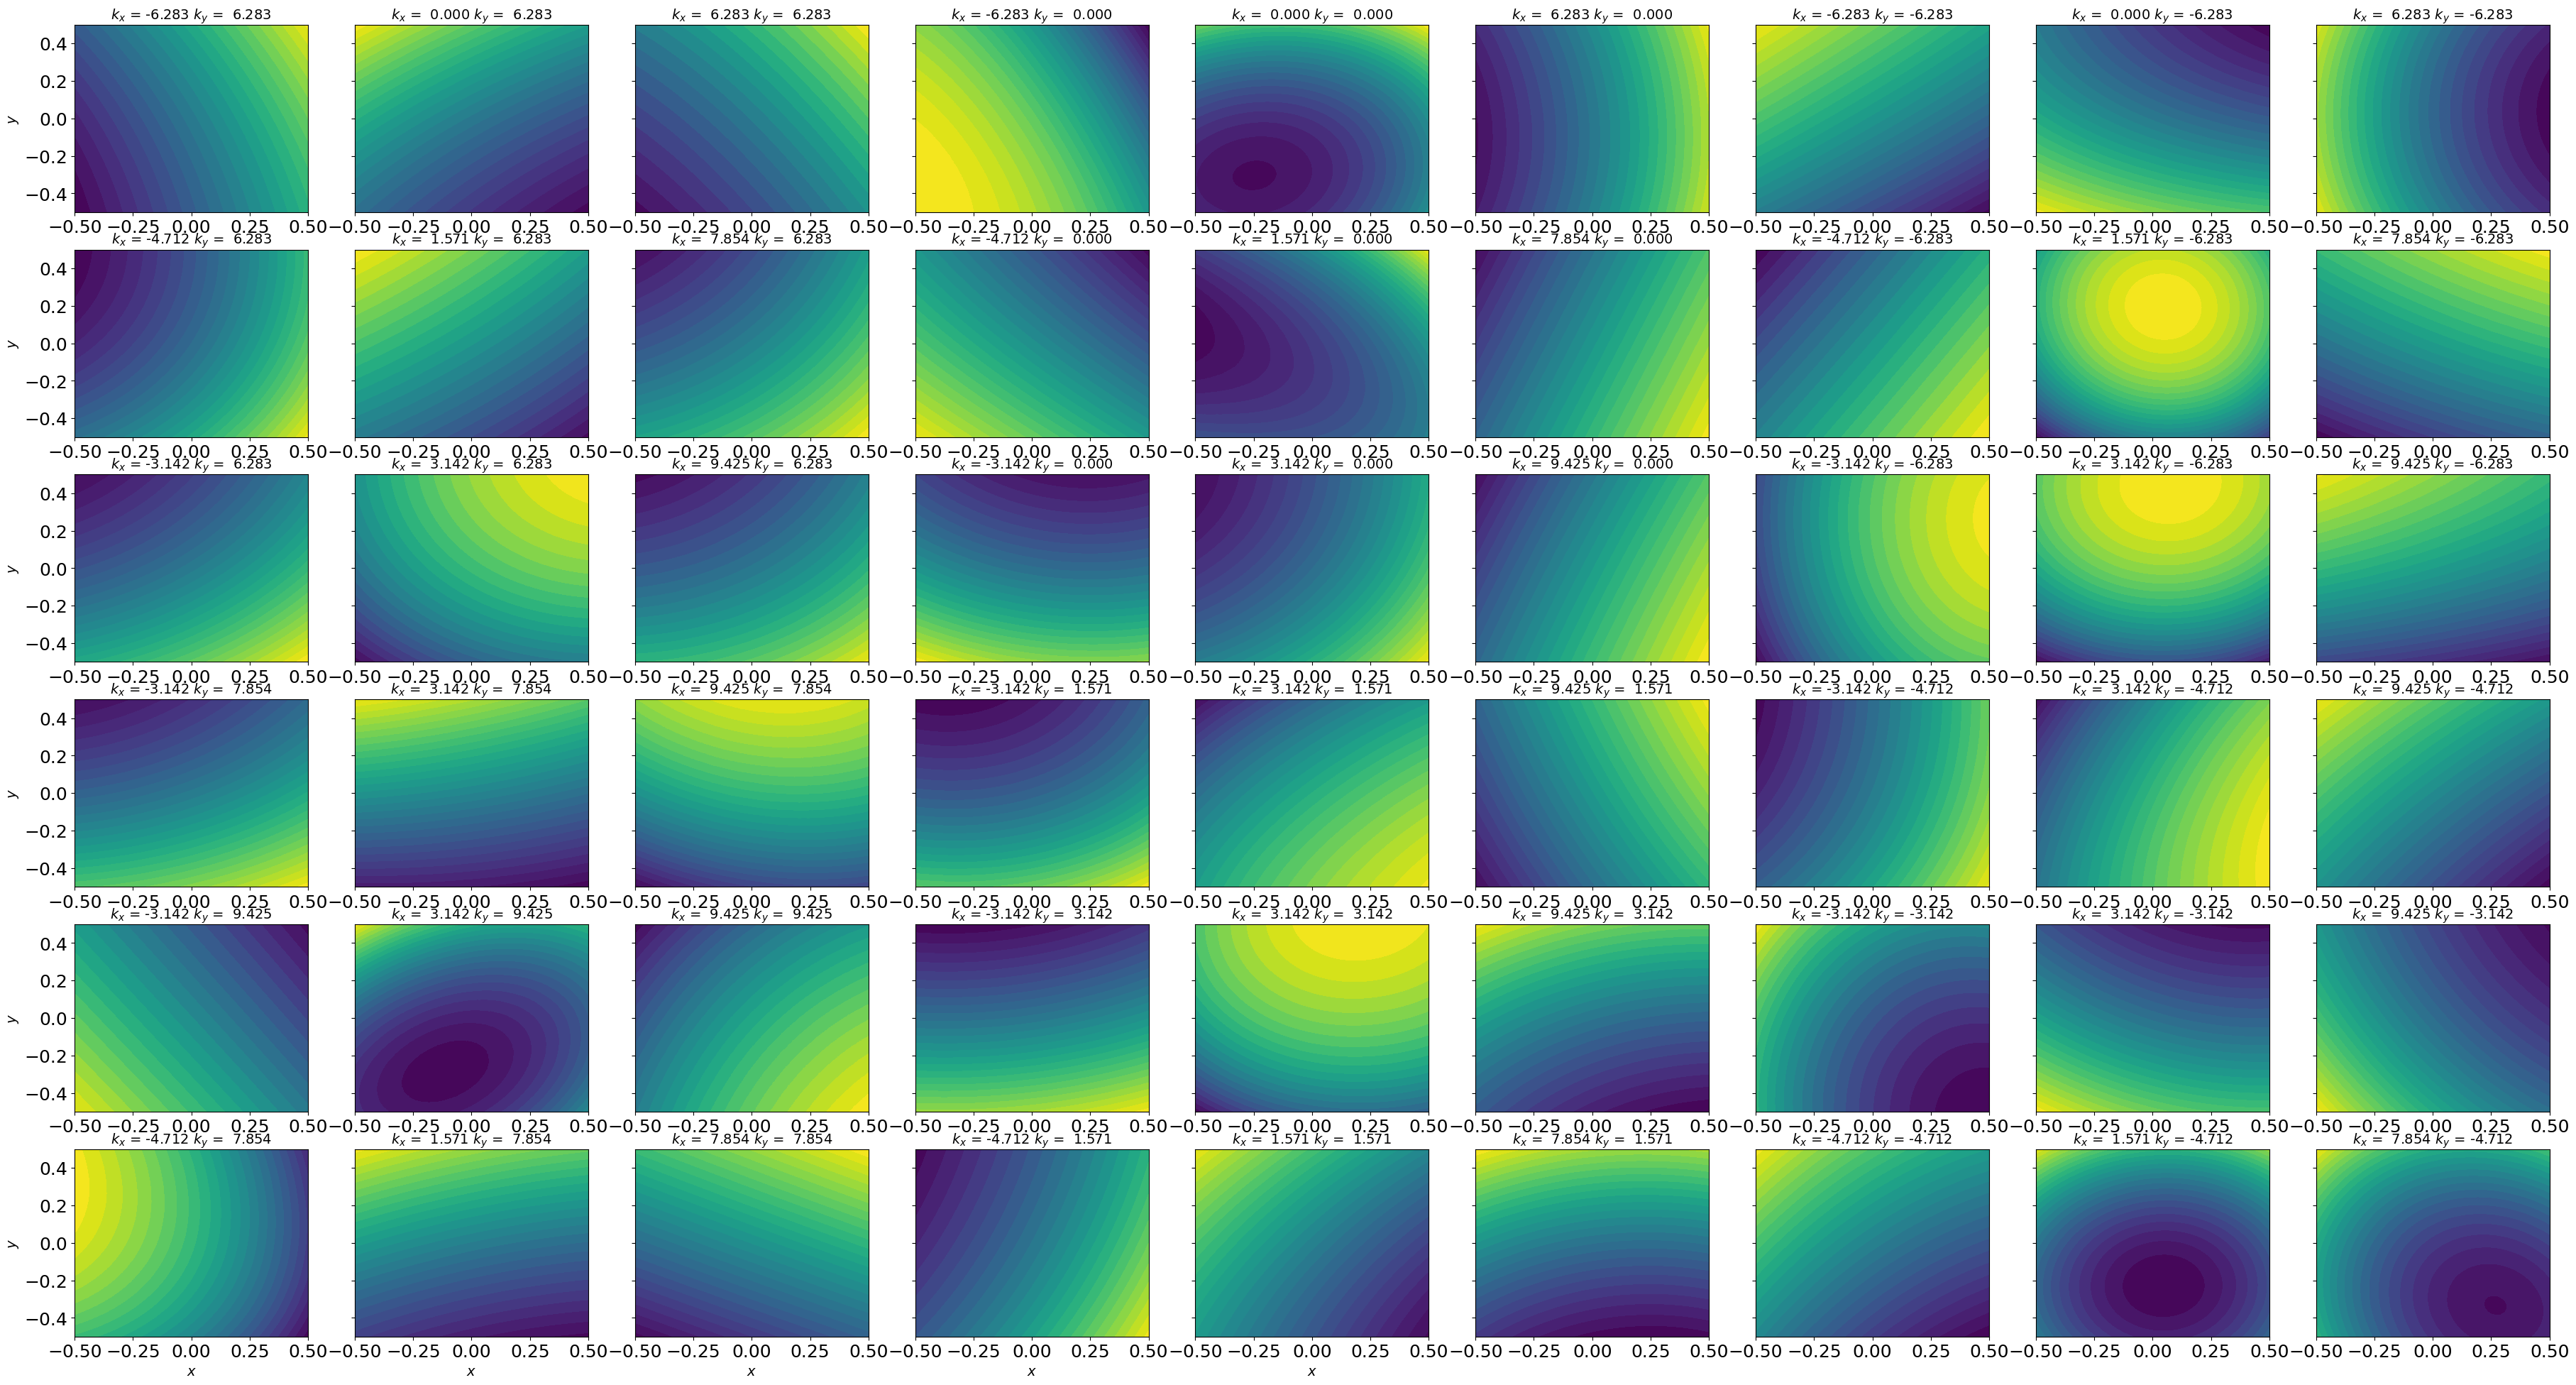

In [33]:
kvals = [
        [0,0],
        [np.pi/2,0],
        [np.pi,0],
        [np.pi,np.pi/2],
        [np.pi,np.pi],
        [np.pi/2,np.pi/2]
        ]

b = [[2*np.pi,0],[0,2*np.pi]]

knum = len(kvals)
fig, ax = plot.subplots(knum, 9, figsize=(45,4*knum), sharey=True)


xval = np.linspace(-0.5,0.5,200) ; yval = np.linspace(-0.5,0.5,200)
grid = torch.cartesian_prod(torch.linspace(-0.5,0.5,200).to(cuda), torch.linspace(-0.5,0.5,200).to(cuda))
b_1 = b[0][0]+b[1][0]; b_2 = b[0][1]+b[1][1]


for i in range(len(kvals)):

    for n in range(9):
        if n == 0:
            b1 = -1; b2 = 1
        elif n == 1:
            b1 = 0; b2 = 1
        elif n == 2:
            b1 = 1; b2 = 1
        elif n == 3:
            b1 = -1; b2 = 0
        elif n == 4:
            b1 = 0; b2 = 0
        elif n == 5:
            b1 = 1; b2 = 0
        elif n == 6:
            b1 = -1; b2 = -1
        elif n == 7:
            b1 = 0; b2 = -1
        elif n == 8:
            b1 = 1; b2 = -1
            
        k_x = b1*b_1 + kvals[i][0] ; k_y = b2*b_2 + kvals[i][1]
        k = torch.cartesian_prod(torch.linspace(k_x,k_x,200).to(cuda), torch.linspace(k_y,k_y,200).to(cuda))
        u,E = nn1(grid[:,0].reshape(-1,1),grid[:,1].reshape(-1,1),k[:,0].reshape(-1,1),k[:,1].reshape(-1,1),V(grid[:,0].reshape(-1,1),grid[:,1].reshape(-1,1)))
        
        
        ax[i,n].contourf(xval,yval,(u[:,0]**2+u[:,1]**2).reshape(200,200).cpu().detach().numpy(),30)
        ax[i,n].set_xlim(-0.5,0.5)
        ax[i,n].set_ylim(-0.5,0.5)
        ax[i,n].set_title('$k_x$ = {:6.3f}'.format(k_x) + ' $k_y$ = {:6.3f}'.format(k_y),fontsize=14)
        ax[i,n].ticklabel_format(useOffset=False, style='plain')
    ax[i,0].set_ylabel('$y$',fontsize=14)
for i in range(5):
    ax[-1,i].set_xlabel('$x$',fontsize=14)

# for i in range(knum):
#     ax[i,4].annotate('$k=${:4.2}'.format(kvals[i]),(1.05,0.5),xycoords='axes fraction',fontsize=14)

Text(3.847222222222216, 0.5, 'y')

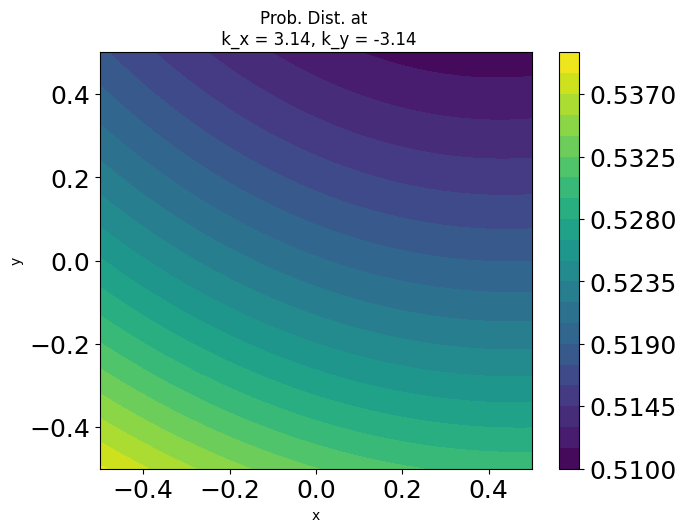

In [35]:
x = torch.linspace(-0.5,0.5,200).to(cuda) ; y = torch.linspace(-0.5,0.5,200).to(cuda)
grid = torch.cartesian_prod(x, y)

kxval = 1*np.pi; kyval = -1*np.pi
kx = torch.linspace(kxval,kxval,200).to(cuda) ; ky = torch.linspace(kyval,kyval,200).to(cuda)

k = torch.cartesian_prod(kx, ky)

u,E = nn1(grid[:,0].reshape(-1,1),grid[:,1].reshape(-1,1),k[:,0].reshape(-1,1),k[:,1].reshape(-1,1),V(grid[:,0].reshape(-1,1),grid[:,1].reshape(-1,1)))

plot.contourf(x.cpu().detach().numpy(),y.cpu().detach().numpy(),(u[:,0]**2+u[:,1]**2).reshape(200,200).cpu().detach().numpy(),20)
plot.tight_layout()
plot.colorbar()
plot.title('Prob. Dist. at \n k_x = ' + str(round(kxval,2)) + ', k_y = ' + str(round(kyval,2)))
plot.xlabel('x')
plot.ylabel('y')


<>:15: SyntaxWarning: invalid escape sequence '\G'
<>:15: SyntaxWarning: invalid escape sequence '\G'
/tmp/ipykernel_249075/1117036864.py:15: SyntaxWarning: invalid escape sequence '\G'
  plot.title('Bloch State at $\Gamma$')


Text(3.847222222222216, 0.5, 'y')

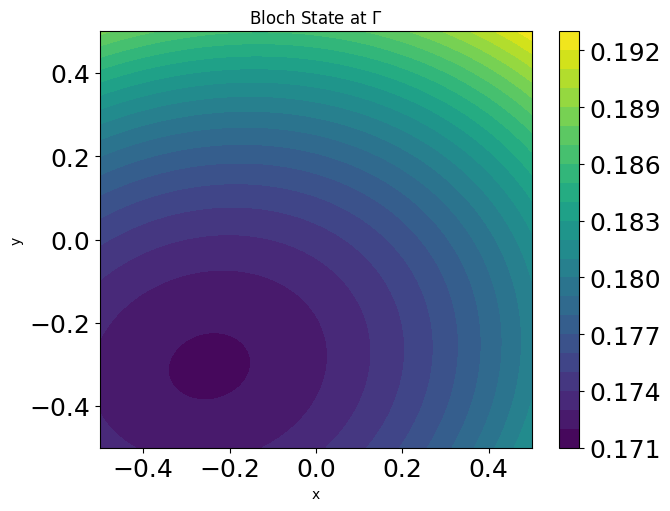

In [36]:
x = torch.linspace(-0.5,0.5,200).to(cuda) ; y = torch.linspace(-0.5,0.5,200).to(cuda)

grid = torch.cartesian_prod(x, y)

kxval = 0*np.pi; kyval = -0*np.pi
kx = torch.linspace(kxval,kxval,200).to(cuda) ; ky = torch.linspace(kyval,kyval,200).to(cuda)

k = torch.cartesian_prod(kx, ky)

u,E = nn1(grid[:,0].reshape(-1,1),grid[:,1].reshape(-1,1),k[:,0].reshape(-1,1),k[:,1].reshape(-1,1),V(grid[:,0].reshape(-1,1),grid[:,1].reshape(-1,1)))

plot.contourf(x.cpu().detach().numpy(),y.cpu().detach().numpy(),(u[:,0]**2+u[:,1]**2).reshape(200,200).cpu().detach().numpy(),20)
plot.tight_layout()
plot.colorbar()
plot.title('Bloch State at $\Gamma$')
plot.xlabel('x')
plot.ylabel('y')

Text(3.847222222222216, 0.5, 'y')

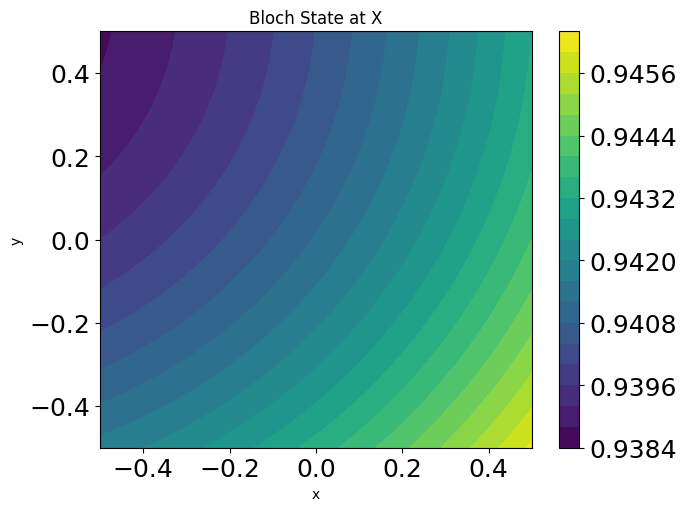

In [37]:
x = torch.linspace(-0.5,0.5,200).to(cuda) ; y = torch.linspace(-0.5,0.5,200).to(cuda)

grid = torch.cartesian_prod(x, y)

kxval = 1*np.pi; kyval = -0*np.pi
kx = torch.linspace(kxval,kxval,200).to(cuda) ; ky = torch.linspace(kyval,kyval,200).to(cuda)

k = torch.cartesian_prod(kx, ky)

u,E = nn1(grid[:,0].reshape(-1,1),grid[:,1].reshape(-1,1),k[:,0].reshape(-1,1),k[:,1].reshape(-1,1),V(grid[:,0].reshape(-1,1),grid[:,1].reshape(-1,1)))

plot.contourf(x.cpu().detach().numpy(),y.cpu().detach().numpy(),(u[:,0]**2+u[:,1]**2).reshape(200,200).cpu().detach().numpy(),20)
plot.tight_layout()
plot.colorbar()
plot.title('Bloch State at X')
plot.xlabel('x')
plot.ylabel('y')

Text(3.847222222222216, 0.5, 'y')

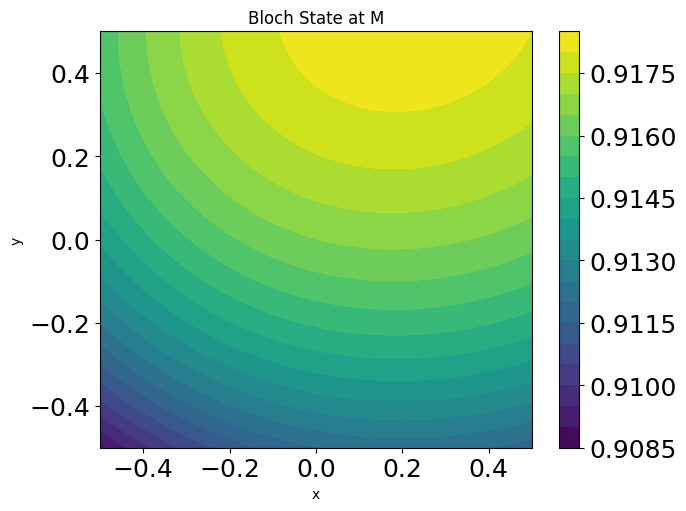

In [38]:
x = torch.linspace(-0.5,0.5,200).to(cuda) ; y = torch.linspace(-0.5,0.5,200).to(cuda)

grid = torch.cartesian_prod(x, y)

kxval = 1*np.pi; kyval = 1*np.pi
kx = torch.linspace(kxval,kxval,200).to(cuda) ; ky = torch.linspace(kyval,kyval,200).to(cuda)

k = torch.cartesian_prod(kx, ky)

u,E = nn1(grid[:,0].reshape(-1,1),grid[:,1].reshape(-1,1),k[:,0].reshape(-1,1),k[:,1].reshape(-1,1),V(grid[:,0].reshape(-1,1),grid[:,1].reshape(-1,1)))

plot.contourf(x.cpu().detach().numpy(),y.cpu().detach().numpy(),(u[:,0]**2+u[:,1]**2).reshape(200,200).cpu().detach().numpy(),20)
plot.tight_layout()
plot.colorbar()
plot.title('Bloch State at M')
plot.xlabel('x')
plot.ylabel('y')

## Numeric Helper Functions

In [42]:
def diagDotProduct(k,g,i):
    return (k[0]-g[i,0])*(k[0]-g[i,0])+(k[1]-g[i,1])*(k[1]-g[i,1])

def buildGrid(shells):
    sq_rad = shells
    x0 = -sq_rad ; x1 = sq_rad ; y0 = -sq_rad ; y1 = sq_rad
    radius = shells**2
    x,y = np.meshgrid(np.linspace(x0,x1,(x1-x0+1)),np.linspace(y0,y1,y1-y0+1))
    grid = np.concatenate((x.reshape(-1,1),y.reshape(-1,1)),-1)
    
    mag = np.sqrt(grid[:,0]**2 + grid[:,0]**2)
    
shells = 100

sq_rad = shells
x0 = -sq_rad ; x1 = sq_rad ; y0 = -sq_rad ; y1 = sq_rad
radius = shells**2
x,y = np.meshgrid(np.linspace(x0,x1,(x1-x0+1)),np.linspace(y0,y1,y1-y0+1))
grid = np.concatenate((x.reshape(-1,1),y.reshape(-1,1)),-1)

mag = np.sqrt(grid[:,0]**2 + grid[:,1]**2)
argsort = np.argsort(mag)

prev = -1
magsort = np.sort(mag)
counter = 0
index = []

for i in range(len(mag)):
    if magsort[i] != prev:
        prev = magsort[i]
        index.append(i)
        
shellsize = []
for i in range(len(index[0:shells])-1):
    shellsize.append(index[i+1]-index[i])
    
bv = []
s = 0
for i in range(len(shellsize)):
    for j in range(shellsize[i]):
        bv.append(grid[argsort[s+j]])
    s += shellsize[i]
    
bv = np.array(bv)

## Perform Fourier Transform

In [43]:
V_c = []
pts = 500

mesh = np.meshgrid(np.linspace(-0.5,0.5,pts),np.linspace(-0.5,0.5,pts))
r = np.concatenate((mesh[0].reshape(-1,1),mesh[1].reshape(-1,1)),-1)
Vx = V(torch.from_numpy(r[:,0]),torch.from_numpy(r[:,1])).numpy()

x = np.linspace(-0.5,0.5,pts) ; y = np.linspace(-0.5,0.5,pts)

time_start = time.time()
print(range(len(bv)))
for i in range(len(bv)):
    
    exp = np.exp(-2j*np.pi*np.dot(r,bv[i]))
    #print(np.dot(r,bv[i]))
    expV = (exp*Vx).reshape(pts,pts)
    V_c.append(np.real_if_close(np.trapz(np.trapz(expV,x=y,axis=1),x=x,axis=0)))
    
fV = 0
for i in range(len(bv)):
    fV += V_c[i]*np.exp(2j*np.pi*np.dot(r,bv[i]))
fV = np.real_if_close(fV)

time_end = time.time()
runTime = time_end - time_start
print(str(round(runTime,2)) + ' seconds')

range(0, 805)
36.72 seconds


Text(0, 0.5, 'V')

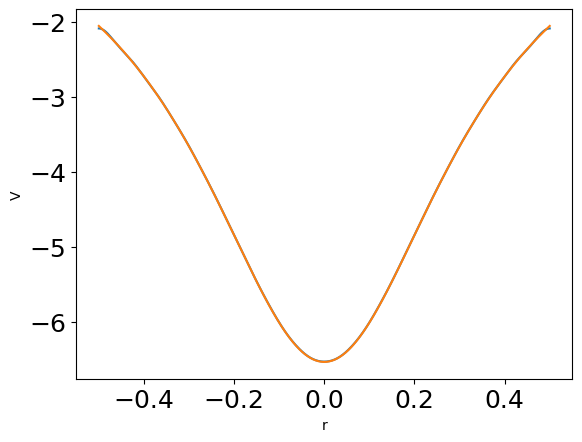

In [44]:
plot.plot(x,fV.reshape(pts,pts)[:,100])
plot.plot(x,Vx.reshape(pts,pts)[:,100])
plot.xlabel('r')
plot.ylabel('V')

Text(3.847222222222216, 0.5, 'V')

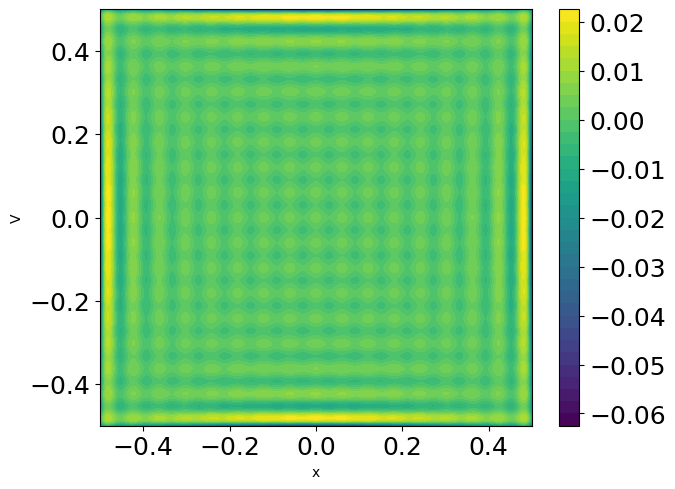

In [45]:
plot.contourf(x,y,fV.reshape(pts,pts)-Vx.reshape(pts,pts),40)
plot.tight_layout()
plot.colorbar()
plot.xlabel('x')
plot.ylabel('V')

## Build Hammy

In [46]:
def findindex(bv,g):
    for i in range(len(bv)):
        if np.all(bv[i] == g):
            return i
    return 0

def hammy(k,bv,V_c,N):
    #print('Building hamiltonian '+str(N)+'x'+str(N))
    H = np.zeros((N,N))
    for i in range(N):
        for j in range(N):
            g = (bv[j]-bv[i])
            
            H[i,j] = V_c[findindex(bv,g)]
    
    
    for i in range(N):
        H[i,i] = (1/2)*diagDotProduct(k,2*np.pi*bv,i)+V_c[0]
        
    return H

In [47]:
b1 = 2*np.pi ; b2 = 2*np.pi
sig = [[-1,1],
      [0,1],
      [1,1],
      [-1,0],
      [0,0],
      [1,0],
      [-1,-1],
      [0,-1],
      [1,-1]]
kx1 = np.linspace(0*np.pi,1*np.pi,100) ; kx2 = np.linspace(1*np.pi,1*np.pi,100) ; kx3 = np.linspace(1*np.pi,0*np.pi,200)
ky1 = np.linspace(0,0,100) ; ky2 = np.linspace(0,1*np.pi,100) ; ky3 = np.linspace(1*np.pi,0*np.pi,200)
kx = np.concatenate((kx1,kx2,kx3),0) ; ky = np.concatenate((ky1,ky2,ky3),0)
k = np.concatenate((kx.reshape(-1,1),ky.reshape(-1,1)),1)


In [48]:
kx1 = np.linspace(0*np.pi,1*np.pi,100) ; kx2 = np.linspace(1*np.pi,1*np.pi,100) ; kx3 = np.linspace(1*np.pi,0*np.pi,200)
ky1 = np.linspace(0,0,100) ; ky2 = np.linspace(0,1*np.pi,100) ; ky3 = np.linspace(1*np.pi,0*np.pi,200)
kx = np.concatenate((kx1,kx2,kx3),0) ; ky = np.concatenate((ky1,ky2,ky3),0)
k = np.concatenate((kx.reshape(-1,1),ky.reshape(-1,1)),1)

N = index[5]



bands = 13

time_start = time.time()

en = []#np.empty([len(k),bands])

logspam = False


print(str(N)+'x'+str(N)+' Hamiltonian')
for i in range(len(k)):
    eig_va, eig_ve = np.linalg.eigh(hammy(k[i],bv,V_c,N))
    #print(eig_va)
    #print(np.sort(eig_va)[0:bands])
    en.append(np.sort(eig_va)[0:bands])
    #print(i)
    if (i+1)%10==0:
        print(str(i+1))
    if logspam:
        print(np.sort(eig_va))
    
time_end = time.time()
runTime = time_end - time_start
print('Completed in ' + str(round(runTime,2)) + ' seconds')

21x21 Hamiltonian
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
Completed in 14.66 seconds


<>:5: SyntaxWarning: invalid escape sequence '\G'
<>:5: SyntaxWarning: invalid escape sequence '\G'
<>:5: SyntaxWarning: invalid escape sequence '\G'
<>:5: SyntaxWarning: invalid escape sequence '\G'
/tmp/ipykernel_249075/4265409064.py:5: SyntaxWarning: invalid escape sequence '\G'
  xlabels = ['$\Gamma$','X','M','$\Gamma$']
/tmp/ipykernel_249075/4265409064.py:5: SyntaxWarning: invalid escape sequence '\G'
  xlabels = ['$\Gamma$','X','M','$\Gamma$']


Text(0, 0.5, 'E')

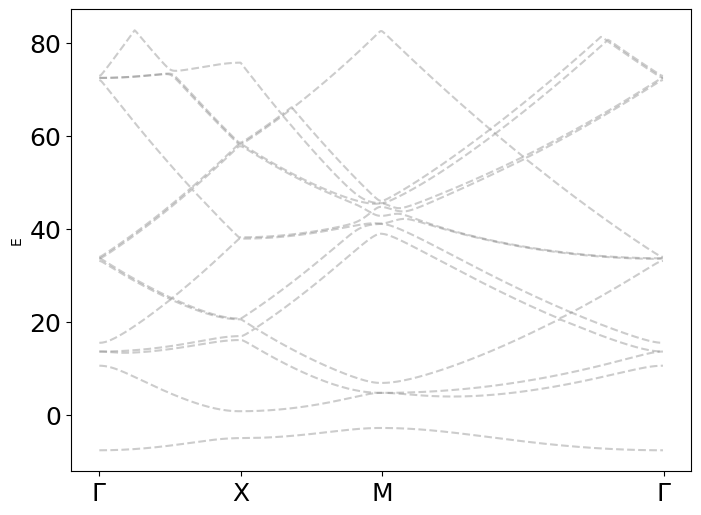

In [49]:
plot.figure(figsize = (8,6))
plot.plot(en,'--',alpha=0.4,color='grey')

xlabelloc = np.array([0,100,200,400])
xlabels = ['$\Gamma$','X','M','$\Gamma$']
plot.xticks(xlabelloc, xlabels)
plot.ylabel('E')
#plot.title('V='+str(V0))

In [ ]:
plot.figure(figsize = (10,8))

b1 = 2*np.pi ; b2 = 2*np.pi
sig = [[-1,1],
      [0,1],
      [1,1],
      [-1,0],
      [0,0],
      [1,0],
      [-1,-1],
      [0,-1],
      [1,-1]]

#sig = [[0,0]]

nn = nn1

pts = 20
x = torch.linspace(-0.5,0.5,400).to(cuda) ; y = torch.linspace(-0.5,0.5,400).to(cuda)
kx1 = np.linspace(0*np.pi,1*np.pi,pts) ; kx2 = np.linspace(1*np.pi,1*np.pi,pts) ; kx3 = np.linspace(1*np.pi,0*np.pi,2*pts)
ky1 = np.linspace(0,0,pts) ; ky2 = np.linspace(0,1*np.pi,pts) ; ky3 = np.linspace(1*np.pi,0*np.pi,2*pts)
kx = np.concatenate((kx1,kx2,kx3),0) ; ky = np.concatenate((ky1,ky2,ky3),0)
k = np.concatenate((kx.reshape(-1,1),ky.reshape(-1,1)),1)

plot.plot(np.linspace(0,4*pts,400),en,'--',alpha=0.4,color='grey')

for b in range(len(sig)):
    for i in range(len(k)):
        plot.plot(i,expectationEnergy(nn,[b1*sig[b][0]+k[i,0],b2*sig[b][1]+k[i,1]],V,100).item(), marker="o", markersize=1, markeredgecolor="black", markerfacecolor="black")

#--------------------------------------------------------------------------------------        
        
x = torch.linspace(1,1,400).to(cuda) ; y = torch.linspace(1,1,400).to(cuda)
kx1 = torch.linspace(0*np.pi,1*np.pi,100).to(cuda) ; kx2 = torch.linspace(1*np.pi,1*np.pi,100).to(cuda) ; kx3 = torch.linspace(1*np.pi,0*np.pi,200).to(cuda)
ky1 = torch.linspace(0,0,100).to(cuda) ; ky2 = torch.linspace(0,1*np.pi,100).to(cuda) ; ky3 = torch.linspace(1*np.pi,0,200).to(cuda)
kx = torch.cat((kx1,kx2,kx3),0) ; ky = torch.cat((ky1,ky2,ky3),0)

NNbands = []#np.empty([len(sig)])

for b in range(len(sig)):
    u,E = nn(x.reshape(-1,1),y.reshape(-1,1),(b1*sig[b][0]+kx).reshape(-1,1),(b2*sig[b][1]+ky).reshape(-1,1),V(x.reshape(-1,1),y.reshape(-1,1)))
    E = E #+ freeEnergySoln((b1*sig[b][0]+kx).reshape(-1,1),(b2*sig[b][1]+ky).reshape(-1,1))
    NNbands.append(E.cpu().detach().numpy())
    plot.plot(np.linspace(0,4*pts,400),NNbands[b])
    

xlabelloc = np.array([0,pts,2*pts,4*pts])
xlabels = ['$\Gamma$','X','M','$\Gamma$']
plot.xticks(xlabelloc, xlabels,fontsize = 16)
plot.ylim(-10,90)
#plot.title('Atomic',fontsize = 24)
#plot.ylabel('E')
plot.yticks(fontsize = 16)
plot.show()

<>:48: SyntaxWarning: invalid escape sequence '\G'
<>:48: SyntaxWarning: invalid escape sequence '\G'
<>:48: SyntaxWarning: invalid escape sequence '\G'
<>:48: SyntaxWarning: invalid escape sequence '\G'
/tmp/ipykernel_249075/3460254181.py:48: SyntaxWarning: invalid escape sequence '\G'
  xlabels = ['$\Gamma$','X','M','$\Gamma$']
/tmp/ipykernel_249075/3460254181.py:48: SyntaxWarning: invalid escape sequence '\G'
  xlabels = ['$\Gamma$','X','M','$\Gamma$']


In [ ]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

In [ ]:
NNEN = np.array(NNbands)[:,:,0]

# for i in NNEN.shape[0]:
#     for j in NNEN.shape[1]:
#         NNEN[i,j] = np.abs(NNEN[i,j]-find_nearest(np.array(en).flatten(),NNEN[i,j]))

for (i,j), _ in np.ndenumerate(NNEN):
    NNEN[i,j] = np.abs(NNEN[i,j]-find_nearest(np.array(en)[j,:].flatten(),NNEN[i,j]))
    
print(NNEN.shape)

In [ ]:
np.array(en)[0,:].shape

In [ ]:
plot.figure(figsize = (10,8))
b1 = 2*np.pi ; b2 = 2*np.pi
sig = [[-1,1],
      [0,1],
      [1,1],
      [-1,0],
      [0,0],
      [1,0],
      [-1,-1],
      [0,-1],
      [1,-1]]

pts = 100
x = torch.linspace(-0.5,0.5,400).to(cuda) ; y = torch.linspace(-0.5,0.5,400).to(cuda)
kx1 = np.linspace(0*np.pi,1*np.pi,pts) ; kx2 = np.linspace(1*np.pi,1*np.pi,pts) ; kx3 = np.linspace(1*np.pi,0*np.pi,2*pts)
ky1 = np.linspace(0,0,pts) ; ky2 = np.linspace(0,1*np.pi,pts) ; ky3 = np.linspace(1*np.pi,0*np.pi,2*pts)
kx = np.concatenate((kx1,kx2,kx3),0) ; ky = np.concatenate((ky1,ky2,ky3),0)
k = np.concatenate((kx.reshape(-1,1),ky.reshape(-1,1)),1)

vals = np.empty((len(sig),len(k)))

for b in range(len(sig)):
    for i in range(len(k)):
        E = expectationEnergy(nn,[b1*sig[b][0]+k[i,0],b2*sig[b][1]+k[i,1]],V,100).item()
        vals[b,i] = np.abs(E-find_nearest(np.array(en)[i,:].flatten(),E))
        
        #plot.plot(i,np.abs(E-find_nearest(np.array(en).flatten(),E)), marker="o", markersize=1, markeredgecolor="black", markerfacecolor="black")
        
plot.plot(np.mean(vals,axis=0))
plot.plot(np.mean(NNEN,axis=0))
xlabelloc = np.array([0,100,200,400])
xlabels = ['$\Gamma$','X','M','$\Gamma$']
plot.xticks(xlabelloc, xlabels)
plot.title('Atomic',fontsize = 24)
plot.ylim(0,1)
#plot.ylabel('$\Delta$E')
plot.yticks([])

In [ ]:
plot.plot(np.mean(vals,axis=1))
plot.plot(np.mean(NNEN,axis=1))
xlabelloc = np.array([0,100,200,400])
xlabels = ['$\Gamma$','X','M','$\Gamma$']
plot.xticks(xlabelloc, xlabels)
plot.title('Atomic',fontsize = 24)
plot.ylim(0,.5)
#plot.ylabel('$\Delta$E')
plot.yticks([])

In [ ]:
plot.figure(figsize = (10,8))
plot.plot(np.mean(vals,axis=1),'--')
plot.plot(np.mean(NNEN,axis=1))
#plot.ylabel('MAE',fontsize = 24)
plot.xlabel('Band',fontsize = 24)
plot.ylim(0,1.2)

In [ ]:
plot.rc('xtick',labelsize=18)
plot.rc('ytick',labelsize=18)

In [ ]:
plot.figure(figsize = (10,8))
plot.plot(vals.transpose(),'--')
plot.gca().set_prop_cycle(None)
plot.plot(NNEN.transpose())
xlabelloc = np.array([0,100,200,400])
xlabels = ['$\Gamma$','X','M','$\Gamma$']
plot.xticks(xlabelloc, xlabels,fontsize = 16)
#plot.ylabel('$\Delta$E',fontsize = 16)
plot.yticks(fontsize = 16)
#plot.title('Constant',fontsize = 24)
plot.yticks([])
plot.ylim(0,1.5)

In [ ]:
EE = np.empty((len(sig),len(k)))
for b in range(len(sig)):
    for i in range(len(k)):
        EE[b,i] = expectationEnergy(nn,[b1*sig[b][0]+k[i,0],b2*sig[b][1]+k[i,1]],V,100).item()

In [ ]:
plot.plot(EE.transpose())

In [ ]:
plot.figure(figsize = (10,8))

b1 = 2*np.pi ; b2 = 2*np.pi
sig = [[-1,1],
      [0,1],
      [1,1],
      [-1,0],
      [0,0],
      [1,0],
      [-1,-1],
      [0,-1],
      [1,-1]]

#sig = [[0,0]]

nn = nn1

x = torch.linspace(-0.5,0.5,400).to(cuda) ; y = torch.linspace(-0.5,0.5,400).to(cuda)
kx1 = torch.linspace(0*np.pi,1*np.pi,100).to(cuda) ; kx2 = torch.linspace(1*np.pi,1*np.pi,100).to(cuda) ; kx3 = torch.linspace(1*np.pi,0*np.pi,200).to(cuda)
ky1 = torch.linspace(0,0,100).to(cuda) ; ky2 = torch.linspace(0,1*np.pi,100).to(cuda) ; ky3 = torch.linspace(1*np.pi,0*np.pi,200).to(cuda)
kx = torch.cat((kx1,kx2,kx3),0) ; ky = torch.cat((ky1,ky2,ky3),0)

NNbands = []#np.empty([len(sig)])

for b in range(len(sig)):
    u,E = nn(x.reshape(-1,1),y.reshape(-1,1),(b1*sig[b][0]+kx).reshape(-1,1),(b2*sig[b][1]+ky).reshape(-1,1),V(x.reshape(-1,1),y.reshape(-1,1)))
    E = E + freeEnergySoln((b1*sig[b][0]+kx).reshape(-1,1),(b2*sig[b][1]+ky).reshape(-1,1))
    NNbands.append(E.cpu().detach().numpy())
    plot.plot(NNbands[b])


plot.plot(en,'--',alpha=0.4,color='grey')
xlabelloc = np.array([0,100,200,400])
xlabels = ['$\Gamma$','X','M','$\Gamma$']
plot.xticks(xlabelloc, xlabels)
plot.title('V='+str(V0))
plot.ylabel('E')

In [ ]:
kx1 = np.linspace(0*np.pi,1*np.pi,100) ; kx2 = np.linspace(1*np.pi,1*np.pi,100) ; kx3 = np.linspace(1*np.pi,0*np.pi,200)
ky1 = np.linspace(0,0,100) ; ky2 = np.linspace(0,1*np.pi,100) ; ky3 = np.linspace(1*np.pi,0*np.pi,200)
kx = np.concatenate((kx1,kx2,kx3),0) ; ky = np.concatenate((ky1,ky2,ky3),0)
k = np.concatenate((kx.reshape(-1,1),ky.reshape(-1,1)),1)

N = index[5]



bands = 13

time_start = time.time()

en = []#np.empty([len(k),bands])

logspam = False


print(str(N)+'x'+str(N)+' Hamiltonian')
for i in range(len(k)):
    eig_va, eig_ve = np.linalg.eigh(hammy(k[i],bv,V_c,N))
    #print(eig_va)
    #print(np.sort(eig_va)[0:bands])
    en.append(np.sort(eig_va)[0:bands])
    #print(i)
    if (i+1)%10==0:
        print(str(i+1))
    if logspam:
        print(np.sort(eig_va))
    
time_end = time.time()
runTime = time_end - time_start
print('Completed in ' + str(round(runTime,2)) + ' seconds')


In [ ]:
plot.figure(figsize = (10,8))

b1 = 2*np.pi ; b2 = 2*np.pi
# sig = [[-1,1],
#       [0,1],
#       [1,1],
#       [-1,0],
#       [0,0],
#       [1,0],
#       [-1,-1],
#       [0,-1],
#       [1,-1]]

sig = [[0,0]]

nn = nn1

x = torch.linspace(1,1,400).to(cuda) ; y = torch.linspace(1,1,400).to(cuda)
kx1 = torch.linspace(0*np.pi+0.05,1*np.pi-0.05,100).to(cuda) ; kx2 = torch.linspace(1*np.pi-0.05,1*np.pi-0.05,100).to(cuda) ; kx3 = torch.linspace(1*np.pi-0.05,0*np.pi+0.05,200).to(cuda)
ky1 = torch.linspace(0.05,0.05,100).to(cuda) ; ky2 = torch.linspace(0.05,1*np.pi-0.05,100).to(cuda) ; ky3 = torch.linspace(1*np.pi-0.05,0.05,200).to(cuda)
kx = torch.cat((kx1,kx2,kx3),0) ; ky = torch.cat((ky1,ky2,ky3),0)

NNbands = []#np.empty([len(sig)])

for b in range(len(sig)):
    u,E = nn(x.reshape(-1,1),y.reshape(-1,1),(b1*sig[b][0]+kx).reshape(-1,1),(b2*sig[b][1]+ky).reshape(-1,1),V(x.reshape(-1,1),y.reshape(-1,1)))
    NNbands.append(E.cpu().detach().numpy())
    plot.plot(NNbands[b])


plot.plot(en,'--',alpha=0.4,color='grey')
plot.plot(1/2*((kx**2).cpu().detach().numpy()+(ky**2).cpu().detach().numpy())-4,'-.',alpha=0.8,color='purple')
xlabelloc = np.array([0,100,200,400])
xlabels = ['$\Gamma$','X','M','$\Gamma$']
plot.xticks(xlabelloc, xlabels)
plot.title('V='+str(V0))
#plot.ylim(-10,10)
plot.ylabel('E')

In [ ]:
print(k[0,0])

In [ ]:
plot.figure(figsize = (10,8))

b1 = 2*np.pi ; b2 = 2*np.pi
sig = [[-1,1],
      [0,1],
      [1,1],
      [-1,0],
      [0,0],
      [1,0],
      [-1,-1],
      [0,-1],
      [1,-1]]

#sig = [[0,0]]

nn = nn1

pts = 20
x = torch.linspace(-0.5,0.5,400).to(cuda) ; y = torch.linspace(-0.5,0.5,400).to(cuda)
kx1 = np.linspace(0*np.pi,1*np.pi,pts) ; kx2 = np.linspace(1*np.pi,1*np.pi,pts) ; kx3 = np.linspace(1*np.pi,0*np.pi,2*pts)
ky1 = np.linspace(0,0,pts) ; ky2 = np.linspace(0,1*np.pi,pts) ; ky3 = np.linspace(1*np.pi,0*np.pi,2*pts)
kx = np.concatenate((kx1,kx2,kx3),0) ; ky = np.concatenate((ky1,ky2,ky3),0)
k = np.concatenate((kx.reshape(-1,1),ky.reshape(-1,1)),1)

NNbands = np.zeros((len(sig),pts*4))

for b in range(len(sig)):
    for i in range(len(k)):
        plot.plot(i,expectationEnergy(nn,[b1*sig[b][0]+k[i,0],b2*sig[b][1]+k[i,1]],V,100).item(), marker="o", markersize=1, markeredgecolor="black", markerfacecolor="black")

xlabelloc = np.array([0,pts,2*pts,4*pts])
xlabels = ['$\Gamma$','X','M','$\Gamma$']
plot.xticks(xlabelloc, xlabels)
plot.title('V='+str(V0))
plot.ylabel('E')
plot.show()